# ПРИ РАСЧЕТЕ СТРАХОВОГО РЕЗЕРВА ПРАВИЛЬНО ОБРАБАТЫВАТЬ МАЛОЕ КОЛ-ВО ТОВАРОВ (ЧТОБЫ ПРИ ОДНОМ ДНЕ С ПРОДАЖАМИ 40 НЕ ВЫДАВАЛ 40)

Коротко: вместо «среднего за 30 дней с весами» используйте адаптивную модель заказа: (1) скоринговый фильтр всплесков, (2) экспоненциальное сглаживание с малым «периодом полураспада», (3) детектор смены режима (последние k дней против предыдущих), (4) расчёт уровня пополнения с учётом срока поставки и страхового запаса. Ниже — готовый рецепт и формулы.

# 1) Фильтр всплесков (winsorize)

Чтобы середина месяца с высоким спросом не «тянула» прогноз вверх:

* Оцените недавний верхний квантиль на окне 30 дней (например, 90-й перцентиль) и обрежьте дневные продажи сверху:

  $d_t^{*} = \min(d_t,\ Q_{0.90}^{(30)})$

Это сохраняет тренд, но гасит одиночные пики/акции.

___
## Дополнение
Коротко:

* **90-й перцентиль на окне 30 дней — это не “взять 3 дня”.**
  Перцентиль — это **порог** $T$, ниже которого \~90 % значений. В отсортированном ряду из 30 точек $T$ будет около между 27-й и 28-й позицией. **Все значения выше $T$** (их может быть 1, 3, 7 и т. д.) будут **срезаны до $T$**. То есть «винзоризация» ограничивает **все** высокие дни, а не ровно три.

* **Зачем 90-й?** Это простой способ обрезать верхний “хвост” (разовые акции/сплески), чтобы они не тянули прогноз. Если доля “акционных” дней ≈10–15 %, логично брать 85–90-й перцентиль; если акций мало — 95-й.

* **«Взять последнюю неделю»** для порога — можно, но это делает порог слишком «нервным» и риск занижения после краткого затишья. Поэтому безопаснее:

  1. оставить P90 на 30 днях, **или**
  2. сделать **комбинированный кап**:
     $\text{cap} = \max\big(\text{median}_{30},\ \min(\text{P90}_{30},\ \text{P90}_{14})\big)$.
     Так порог не будет выше старых пиков и не упадёт слишком низко из-за пары тихих дней.
  3. ещё лучше — **экспоненциально-взвешенный квантиль** (вес свежих дней больше): P90 с half-life 5–7 дней. Это даёт “последнюю неделю” больше веса, но без резких перегибов.

* **Как выбирать на практике**

  * Если в данных бывают 1–2 коротких промо-пика в месяц → **P90 на 30 днях** обычно достаточно.
  * Если пиков много → снизить до **P85** или сократить окно до **14 дней**.
  * Если хотите сильнее учитывать «сегодняшний» режим → **взвешенный квантиль** (half-life 5–7 дней).

* **Применительно к вашему ряду** (то, что я уже прогнал): P90 на 30 днях с EWMA/медианой отработал нормально: убрал «жирную середину» и не занижал в конце. Переход на «последнюю неделю» для кэпа, вероятно, ещё снизит запас, но повысит риск недозаказа при возврате к среднему.

Если хотите — могу включить в код **взвешенный квантиль** (как для медианы, только q=0.9) и прогнать абляцию: P85/P90/P95; окна 7/14/30; сравнить fill rate и средний запас на ваших данных.
___

# 2) Экспоненциальное сглаживание с полураспадом

Используйте EWMA, где более свежие дни получают экспоненциально большие веса.

* Полураспад $h$ (в днях): за $h$ дней вклад уменьшается вдвое. Рекомендую $h=5$–7 для чувствительности к последней неделе.

* Параметр сглаживания:

  $\alpha = 1 - 2^{-1/h}$

* Обновление уровня (оценка среднесуточного спроса):

  $\lambda_t = \alpha\, d_t^{*} + (1-\alpha)\,\lambda_{t-1}$

* Оценка дисперсии остатков для страхового запаса (тем же экспоненциальным весом, $\gamma \approx \alpha$):

  $e_t = d_t^{*} - \lambda_{t-1}$
  $s_t^2 = \gamma\, e_t^2 + (1-\gamma)\, s_{t-1}^2$

___
## Дополнение

Окей, разберём «экспоненциальное сглаживание с полураспадом» по шагам — без лишней математики, но точно.

# Что мы хотим

Получать **текущий уровень среднесуточного спроса** $\lambda_t$, который быстро реагирует на последние дни, но не прыгает из-за одиночных всплесков.

# Подготовка входа

Перед сглаживанием мы **обрезаем пики** (winsorize):
берём, например, P90 за 30 дней и заменяем все значения выше порога на сам порог. Получаем $d_t^{*}$. Это гасит промо-всплески.

# Идея сглаживания

Вместо «простого среднего» считаем **взвешенное среднее с экспоненциальным спадом весов**: свежие дни получают больший вес, старые — всё меньше.

Рекуррентная формула:

$$
\lambda_t \;=\; \alpha\cdot d_t^{*} \;+\; (1-\alpha)\cdot \lambda_{t-1}
$$

* $\lambda_t$ — оценка «сегодняшнего» среднего спроса;
* $d_t^{*}$ — сегодняшняя продажа после обрезки пиков;
* $\alpha\in(0,1)$ — сколько «доверяем» последнему дню.

Это эквивалентно бесконечной взвешенной сумме:

$$
\lambda_t = \underbrace{\alpha}_{\text{вес сегодня}}\!d_t^{*}
+ \underbrace{\alpha(1-\alpha)}_{\text{вес вчера}}\!d_{t-1}^{*}
+ \alpha(1-\alpha)^2 d_{t-2}^{*} + \ldots
$$

То есть веса убывают геометрически.

# Полураспад и как из него получить $\alpha$

Параметр, понятный «временем», — **период полураспада** $h$ (в днях): вклад дня, который был $h$ дней назад, **вдвое меньше**, чем вклад сегодняшнего.

Это задаёт связь:

$$
(1-\alpha)^h = \tfrac{1}{2}
\;\;\Rightarrow\;\;
\alpha = 1 - 2^{-1/h}.
$$

Примеры:

* $h=5$ → $\alpha \approx 0{,}129$.
  Вес вчерашнего дня = $0{,}129\times(1-0{,}129)\approx 0{,}112$;
  вес 5 дней назад ≈ половина веса сегодняшнего.
* $h=7$ → $\alpha \approx 0{,}091$ (реагирует медленнее, сглаживает сильнее).

Интуитивно: при $h=5$ \~**78%** суммарного веса дают последние \~11 дней, при $h=7$ — последние \~15–16 дней.

# Инициализация

В первый день истории задаём $\lambda_0$ просто и стабильно, например:

* средним за первые 5 дней (что есть), или
* равным первому наблюдению.

Дальше формула сама «едет» день за днём.

# Оценка разброса (для страхового запаса)

Чтобы посчитать страховой запас, параллельно оцениваем дисперсию остатков тем же экспоненциальным весом:

$$
e_t = d_t^{*} - \lambda_{t-1},\quad
s_t^2 = \gamma\, e_t^2 + (1-\gamma)\, s_{t-1}^2,
$$

где обычно $\gamma=\alpha$. Тогда на горизонте $H=L+R$ берём запас:

$$
SS = z\cdot s_t\cdot \sqrt{H}.
$$

# Пошаговый алгоритм (как «крутится» каждый день)

1. берёте сегодняшние продажи $d_t$;
2. обрезаете пики → $d_t^{*}=\min(d_t,\text{P90}_{30})$;
3. обновляете уровень: $\lambda_t = \alpha d_t^{*} + (1-\alpha)\lambda_{t-1}$;
4. обновляете разброс: $s_t^2 = \alpha e_t^2 + (1-\alpha)s_{t-1}^2$;
5. считаете целевой уровень под горизонт $H=L+R$:
   $S = \lambda_t\cdot H + z\cdot s_t\sqrt{H}$;
6. считаете заказ «под уровень»:
   $q = \max\{0,\; S - \text{OnHand}_t - \text{OnOrder, приходящее до }L\}$.

# Маленький числовой пример (h=5)

* $h=5 \Rightarrow \alpha \approx 0{,}129$.
* Пусть вчера $\lambda_{t-1}=100$, а сегодня $d_t^{*}=80$.
  Тогда $\lambda_t = 0{,}129\cdot80 + 0{,}871\cdot100 = 97{,}4$.
  На следующий день при $d_{t+1}^{*}=60$:
  $\lambda_{t+1}=0{,}129\cdot60+0{,}871\cdot97{,}4\approx 92{,}6$.
  Видно: уровень меняется плавно и «тянется» к текущим значениям.

# Как выбрать $h$

* Быстрые изменения спроса → **меньше $h$** (3–5), модель более «нервная».
* Стабильный товар, много шума → **больше $h$** (7–10), модель стабильнее.
* Для вашего кейса я использовал базово $h=5$ и показал чувствительность в симуляциях.

---

Покажем ту же кривую $\lambda_t$ на вашем ряду при $h=3,5,7$ на одном графике, чтобы было видно, как меняется «инерция».

<img src="data/img/output3.png" width=980 height=480 />

___

# 3) Детектор смены режима (быстрое «похолодание» спроса)

Сравните среднее за последние $k$ дней с предыдущим фоном:

* $\mu_{\text{recent}} = \text{avg}(d_{t-k+1}^{*},\ldots,d_t^{*})$
* $\mu_{\text{prev}} = \text{avg}(d_{t-k-m+1}^{*},\ldots,d_{t-k}^{*})$

Параметры: $k=5$, $m=15$.

Если наблюдается резкое падение,

$$
\frac{\mu_{\text{recent}}}{\mu_{\text{prev}}} < r_{\downarrow}\quad\text{(например }r_{\downarrow}=0.7\text{)}
$$

то «перезапускайте» состояние под текущий уровень:

* установить $\lambda_t \leftarrow \mu_{\text{recent}}$,
* временно сделать модель более «нервной» (уменьшите $h$ до 3–4 дней на 3–5 следующих обновлений).

Это предотвращает ситуацию, когда «жирная» середина месяца перевешивает последние 5–10 дней.

> Альтернатива ещё более робастная к пикам: **экспоненциально-взвешенная медиана** вместо среднего. Практически — посчитать медиану с весами $w_i \propto 2^{-(\text{возраст}_i/h)}$. Она меньше реагирует на кратковременные всплески, чем EWMA.

# 4) Уровень пополнения и количество заказа

Заказываем по политике «под уровень» (order-up-to):

* Пусть $L$ — срок поставки (в днях), $R$ — период между пересмотрами заказа (в днях).

* Прогноз спроса на горизонт $H=L+R$:

  $\widehat{D}_H = \lambda_t \cdot H$
  (если есть сильная недельная сезонность — умножайте $\lambda_t$ на индекс дня недели; см. примечание ниже)

* Страховой запас при целевом уровне сервиса $SL$ (например, 95% → $z\approx1{,}65$):

  $SS = z \cdot s_t \cdot \sqrt{H}$

* Целевой уровень запасов:

  $S = \widehat{D}_H + SS$

* Количество к заказу с учётом имеющихся остатков и уже в пути до даты $t+L$:

  $q = \max\big(0,\ S - \text{OnHand}_t - \text{OnOrder\_arriving\_by}(t+L)\big)$

### Значения по умолчанию

* Полураспад $h=5$ (последняя неделя решает), $\alpha = 1 - 2^{-1/5} \approx 0{,}129$.
  При «перезапуске» после падения спроса: временно $h=3$ ($\alpha\approx 0{,}206$).
* $k=5,\ m=15,\ r_{\downarrow}=0.7$.
* Уровень сервиса: 90% → $z=1.28$, 95% → $z=1.65$, 97.5% → $z=1.96$, 99% → $z=2.33$.

___
## Дополнительно
Ниже — «под уровень» (order-up-to) разложено по элементам. Ключевые символы: **$z$** и **$s_t$**.

# 1) Что такое $S$ и из чего он состоит

Целевой уровень запасов на горизонте $H=L+R$:

$$
S \;=\; \underbrace{\lambda_t \cdot H}_{\text{ожидаемый спрос за }H}
\;+\; \underbrace{z \cdot \sigma_H}_{\text{страховой запас}}
$$

* $L$ — срок поставки (дней).
* $R$ — периодичность пересмотра заказа (дней).
* $H=L+R$ — горизонт, который должен быть закрыт текущим решением.
* $\lambda_t$ — оценка текущего среднесуточного спроса (мы считаем её через EWMA).
* $\sigma_H$ — стандарт-отклонение суммарного спроса за горизонт $H$.
* $z$ — квантиль стандартного нормального распределения под **целевой уровень сервиса**.

# 2) Что такое $z$

Это множитель «во сколько σ» мы хотим держать буфер, чтобы вероятность дефицита была не выше заданной.

Типовые соответствия (Cycle Service Level, вероятность «без дефицита» за цикл):

* 90% ⇒ $z \approx 1.28$
* 95% ⇒ $z \approx 1.65$
* 97.5% ⇒ $z \approx 1.96$
* 99% ⇒ $z \approx 2.33$

> Замечание: эти $z$ соответствуют **вероятности бездефицитного цикла** (CSL). Это не то же самое, что fill rate по единицам, но на практике это удобный и стандартный таргет.

# 3) Что такое $s_t$ (и чем он отличается от $s_t^2$)

* $s_t$ — наша **оценка стандарт-отклонения суточного спроса** (после сглаживания уровня).
* В коде мы храним **дисперсию** $s_t^2$ (переменная `s2`) и обновляем её экспоненциально:

  $$
  e_t=d_t^{*}-\lambda_{t-1},\quad
  s_t^2 \leftarrow \gamma\,e_t^2 + (1-\gamma)\,s_t^2
  $$

  где $d_t^{*}$ — продажи с «обрезкой пиков» (winsorize), $\gamma\approx\alpha$ (тот же темп, что и для уровня).
* Само $s_t$ — это $\sqrt{s_t^2}$.

# 4) Как получить $\sigma_H$ (разброс за горизонт)

### Если $L$ фиксирован и независим:

$$
\sigma_H \;=\; s_t \cdot \sqrt{H}
$$

(вариация суммы $H$ независимых дней)

### Если $L$ случайный (например, 6–10 дней):

$$
\sigma_H \;=\; \sqrt{\;\underbrace{s_t^2 \cdot H}_{\text{шум спроса}}
\;+\; \underbrace{\lambda_t^2 \cdot \mathrm{Var}(L)}_{\text{вариация срока поставки}}\;}
$$

Пример: $L\sim\text{Uniform}\{6,\ldots,10\}\Rightarrow \mathbb{E}[L]=8,\ \mathrm{Var}(L)=2$.

# 5) Итоговая формула страхового запаса

$$
SS \;=\; z \cdot \sigma_H
$$

и целевой уровень:

$$
S = \lambda_t H + SS
$$

# 6) Сколько заказывать

$$
q \;=\; \max\bigl(0,\ S - \underbrace{\text{OnHand}_t}_{\text{на руках}} - \underbrace{\text{OnOrder}_{\le L}}_{\text{придёт в ближайшие }L\text{ дней}}\bigr)
$$

(вычитаем только то, что действительно успеет прийти до конца lead-time — это снижает риск недозаказа).

# 7) Короткий числовой пример

Пусть $\lambda_t=25$ шт/день, $s_t=12$ шт/день, $L=8$, $R=1$ ⇒ $H=9$, цель 95% ⇒ $z=1.65$.

* **Фиксированный L=8**: $\sigma_H = 12\sqrt{9}=36$.
  $SS = 1.65\cdot 36=59.4$.
  $S = 25\cdot 9 + 59.4 = 284.4$.
  Если OnHand=200, и в пути за $L$ придёт 40 ⇒ $q=\max(0, 284.4-240)=44.4$ ≈ **44 шт**.

* **Переменный L∈\[6..10]** ($\mathrm{Var}(L)=2$):
  $\sigma_H=\sqrt{12^2\cdot 9 + 25^2\cdot 2}=\sqrt{1296+1250}\approx 50.5$.
  $SS=1.65\cdot 50.5\approx 83.3$.
  $S=225+83.3=308.3$ ⇒ $q\approx 68$ шт.
  (Буфер выше, т.к. сам срок поставки «гуляет».)

# 8) Что важно помнить

* $z$ выбираете под бизнес-SLA на цикл. Чем выше — тем реже дефициты и тем больше средний запас.
* $s_t$ — это **стандарт-отклонение** суточного спроса в текущем режиме; его мы оцениваем экспоненциально, чтобы оно успевало адаптироваться.
* Если спрос «рваный» (много нулей) — лучше специальная модель (Croston/SBA), иначе $s_t$ будет завышать буфер.
* Если есть недельная сезонность — прогноз $\lambda_t$ умножайте на индексы дня недели, а $\sigma_H$ считаете по скорректированным остаткам.

Если хотите, применю обе версии формулы **на ваших данных** (фиксированный L=8 и случайный 6–10) и покажу вклад каждого слагаемого в $SS$ и $S$ по дням — будет сразу видно, «из чего растёт» заказ.

___


# 5) Недельная сезонность (если заметна)

Учтите день-недели: храните 7 сезонных индексов $s_{dow}$ (экспоненциально обновляемых) с нормировкой $\sum s_{dow}/7=1$. Тогда прогноз на день $t+i$:

$$
\widehat{d}_{t+i} = \lambda_t \cdot s_{\text{dow}(t+i)}
$$

и $\widehat{D}_H = \sum_{i=1}^H \widehat{d}_{t+i}$. Это часто снижает переоценку после «шумной» середины месяца.

---

## Псевдокод (Python-стиль)

```python
def order_qty(
    last_30_days, on_hand, on_order_arrivals_by_L, L, R,
    service_level=0.95, h=5, k=5, m=15, r_down=0.7,
    h_after_break=3, quantile_cap=0.90, use_weighted_median=False
):
    import math
    # 1) winsorize по верхнему квантилю
    q_cap = np.quantile(last_30_days, quantile_cap)
    d = np.minimum(last_30_days, q_cap)

    # 2) оценка уровня λ и дисперсии s^2
    def alpha_from_half_life(h): return 1 - 2**(-1.0/h)
    alpha = alpha_from_half_life(h)
    lam = np.mean(d[:5])  # инициализация
    s2 = np.var(d[:5]) if len(d) >= 5 else 0.0
    gamma = alpha
    for x in d:
        e = x - lam
        s2 = gamma*(e*e) + (1-gamma)*s2
        lam = alpha*x + (1-alpha)*lam

    # 3) детектор смены режима
    if len(d) >= k + m:
        mu_recent = np.mean(d[-k:])
        mu_prev   = np.mean(d[-(k+m):-k])
        if mu_prev > 0 and (mu_recent/mu_prev) < r_down:
            lam = mu_recent
            # сделать модель «нервнее» на ближайший горизонт
            alpha = alpha_from_half_life(h_after_break)
            # можно дополнительно снизить s2 (новый режим тише)
            s2 = max(s2 * 0.5, 1e-6)

    # (опционально) взвешенная медиана вместо EWMA
    if use_weighted_median:
        ages = np.arange(len(d))[::-1]  # 0 для последнего дня
        w = 0.5**(ages/float(h))        # экспоненциальные веса
        lam = weighted_quantile(d, 0.5, sample_weight=w)  # медиана

    # 4) заказ под уровень
    H = L + R
    z = {0.90:1.28, 0.95:1.65, 0.975:1.96, 0.99:2.33}.get(service_level, 1.65)
    demand_forecast = lam * H
    safety_stock = z * math.sqrt(max(s2, 1e-6)) * math.sqrt(H)
    S = demand_forecast + safety_stock

    q = max(0.0, S - on_hand - on_order_arrivals_by_L)
    return round(q)
```

> Реализация `weighted_quantile` — стандартная: сортировка по значению, накопление весов до 50% суммарного веса.

---

## Почему это решит вашу ситуацию

* **Winsorize + EWMA** гасит локальные пики в середине месяца.
* **Детектор смены режима** обрывает влияние «жирной» середины, если последние 5–10 дней явно ниже.
* **Страховой запас** не даёт «урезать до нуля» при шуме.
* **Период полураспада** настраивается предметно: чем быстрее меняется спрос, тем меньше $h$.

Если потребуется, могу адаптировать под ваш стек (ClickHouse-запросы + расчёты в Python/GS, индексы по дням недели, исключение промо-дней, отдельная логика для редких продаж/Croston).


____
____

Ок, делаем рабочий, самодостаточный вариант с понятными параметрами, комментариями и примером. Ошибка `weighted_quantile is not defined` была потому, что в псевдокоде она не была реализована. Ниже — **готовая функция** с документацией и реализацией `weighted_quantile`. Никаких внешних зависимостей (только стандартная библиотека).

---

### Что подставлять на вход

* `last_30_days`: список из 30 чисел — продажи по дням (шт/день) за последние 30 календарных дней (0 разрешён).
* `on_hand`: текущий остаток на складе (шт).
* `on_order_arrivals_by_L`: суммарное количество уже заказанного товара, которое успеет приехать **в течение срока поставки L** (шт).
* `L`: срок поставки в днях (lead time).
* `R`: периодичность пересмотра заказа в днях (обычно `1`, если проверяете ежедневно).
* Остальные параметры — тюнинг (дефолты ниже подходят большинству кейсов).

Рекомендуемые значения по умолчанию:
`service_level=0.95`, `h=5`, `k=5`, `m=15`, `r_down=0.7`, `h_after_break=3`, `quantile_cap=0.90`, `use_weighted_median=False`.

---

### Готовый код (скопируйте как есть)

```python
import math
from typing import List, Tuple, Dict, Any

def _percentile(a: List[float], p: float) -> float:
    """Непараметрический персентиль (линейная интерполяция). p в [0,1]."""
    if not a:
        return 0.0
    a_sorted = sorted(a)
    k = (len(a_sorted) - 1) * p
    f = math.floor(k)
    c = math.ceil(k)
    if f == c:
        return float(a_sorted[int(k)])
    return a_sorted[f] * (c - k) + a_sorted[c] * (k - f)

def _weighted_quantile(values: List[float], q: float, weights: List[float]) -> float:
    """
    Взвешенный квантиль q в [0,1]. Если веса нулевые/пусто, падение в невзвешенный персентиль.
    """
    if not values:
        return 0.0
    if not weights or sum(weights) <= 0:
        return _percentile(values, q)
    # Сортируем по значениям
    pairs = sorted(zip(values, weights), key=lambda x: x[0])
    vals = [v for v, _ in pairs]
    wts = [max(0.0, w) for _, w in pairs]
    total = sum(wts)
    target = q * total
    cum = 0.0
    for i, (v, w) in enumerate(zip(vals, wts)):
        prev = cum
        cum += w
        if cum >= target:
            # Линейная интерполяция внутри отрезка (если нужно)
            if w == 0:
                return float(v)
            frac = (target - prev) / w
            if i == 0:
                return float(v)
            return vals[i-1] * (1 - frac) + v * frac
    return float(vals[-1])

def _alpha_from_half_life(h: float) -> float:
    """Перевод половинного периода (в днях) в коэффициент EWMA."""
    h = max(1e-6, float(h))
    return 1.0 - 2.0 ** (-1.0 / h)

def order_qty(
    last_30_days: List[float],
    on_hand: float,
    on_order_arrivals_by_L: float,
    L: int,
    R: int,
    service_level: float = 0.95,
    h: float = 5.0,
    k: int = 5,
    m: int = 15,
    r_down: float = 0.7,
    h_after_break: float = 3.0,
    quantile_cap: float = 0.90,
    use_weighted_median: bool = False,
    return_details: bool = True,
) -> Tuple[int, Dict[str, Any]]:
    """
    Рассчитывает количество к заказу по политике "под уровень" с учётом нелинейного спроса.
    Шаги: winsorize, EWMA, детектор снижения режима, страховой запас.

    Параметры:
      last_30_days: продажи/день за последние 30 дней (список длиной <= 30, допускаются нули).
      on_hand: текущий складской остаток (шт).
      on_order_arrivals_by_L: уже заказано и приедет в течение L дней (шт).
      L: срок поставки (дни).
      R: период пересмотра (дни), обычно 1.
      service_level: целевой уровень сервиса (напр. 0.95 → z≈1.65).
      h: половинный период EWMA (чувствительность к последней неделе). Типично 5–7.
      k, m: окна детектора смены режима (последние k против предыдущих m).
      r_down: порог падения (если recent/prev < r_down → обнуляем состояние на низкий режим).
      h_after_break: временно более короткий half-life после детекта падения.
      quantile_cap: верхний квантиль для обрезки всплесков (winsorize), напр. 0.90.
      use_weighted_median: если True — использовать экспоненциально-взвешенную медиану вместо EWMA.
      return_details: если True, вернуть словарь с промежуточными расчётами.

    Возвращает:
      (q, details), где q — округлённое количество к заказу (int),
      details — словарь с диагностикой (уровень λ, дисперсия, прогноз, SS, S и т.п.).
    """
    # Санитация и обрезка входа
    d_raw = [max(0.0, float(x)) for x in last_30_days][-30:]
    if not d_raw:
        d_raw = [0.0]

    # 1) Winsorize по верхнему квантилю
    cap = _percentile(d_raw, max(0.0, min(1.0, quantile_cap)))
    d = [min(x, cap) for x in d_raw]

    # 2) EWMA: уровень λ и дисперсия остатков s^2
    alpha = _alpha_from_half_life(h)
    gamma = alpha
    # Инициализация λ и s2: среднее/дисперсия по первым min(5, len(d)) точкам
    init_n = min(5, len(d))
    lam = sum(d[:init_n]) / init_n
    # Несмещённость нам не критична: берём простую дисперсию
    mean0 = lam
    s2 = sum((x - mean0) ** 2 for x in d[:init_n]) / max(1, init_n)

    for x in d:
        e = x - lam
        s2 = gamma * (e * e) + (1.0 - gamma) * s2
        lam = alpha * x + (1.0 - alpha) * lam

    # 3) Детектор смены режима (падение спроса)
    mu_recent = mu_prev = ratio = None
    broke_regime = False
    if len(d) >= k + m and k > 0 and m > 0:
        mu_recent = sum(d[-k:]) / k
        mu_prev   = sum(d[-(k + m):-k]) / m
        if mu_prev > 0:
            ratio = mu_recent / mu_prev
            if ratio < r_down:
                # Перезапуск уровня на недавний режим
                lam = mu_recent
                alpha = _alpha_from_half_life(h_after_break)
                s2 = max(s2 * 0.5, 1e-6)
                broke_regime = True

    # (Опция) экспоненциально-взвешенная медиана вместо EWMA
    if use_weighted_median:
        ages = list(range(len(d)))[::-1]  # 0 для последнего дня
        weights = [0.5 ** (age / max(1e-6, h)) for age in ages]
        lam = _weighted_quantile(d, 0.5, weights)

    # 4) Заказ "под уровень"
    H = int(L) + int(R)
    H = max(1, H)
    z_table = {0.90: 1.28, 0.95: 1.65, 0.975: 1.96, 0.99: 2.33}
    # Берём ближайшее известное z или дефолт 1.65
    z = min(z_table.items(), key=lambda kv: abs(kv[0] - service_level))[1]

    demand_forecast = lam * H
    safety_stock = z * math.sqrt(max(s2, 1e-12)) * math.sqrt(H)
    S = demand_forecast + safety_stock

    q = max(0.0, S - float(on_hand) - float(on_order_arrivals_by_L))
    q_rounded = int(round(q))

    details = {
        "lambda_level": lam,
        "variance_s2": s2,
        "alpha": alpha,
        "cap_quantile": quantile_cap,
        "cap_value": cap,
        "detector": {
            "broke_regime": broke_regime,
            "k": k, "m": m, "r_down": r_down,
            "mu_recent": mu_recent, "mu_prev": mu_prev, "ratio": ratio,
        },
        "h": h, "h_after_break": h_after_break,
        "H": H, "z": z,
        "demand_forecast_H": demand_forecast,
        "safety_stock": safety_stock,
        "target_S": S,
        "on_hand": float(on_hand),
        "on_order_arrivals_by_L": float(on_order_arrivals_by_L),
        "q_continuous": q,
    }

    return (q_rounded, details) if return_details else (q_rounded, {})
```

---

### Мини-пример использования

```python
# Продажи за 30 дней: низко → пик в середине → снова низко
last_30 = [2,2,3,1,0,  2,3,2,3,2,  10,12,9,11,10,  3,2,2,1,2,  1,1,0,2,1,  1,2,1,1]
on_hand = 120
on_order_arrivals_by_L = 50
L = 7   # доставка 7 дней
R = 1   # проверяем каждый день

q, info = order_qty(
    last_30, on_hand, on_order_arrivals_by_L, L, R,
    service_level=0.95,
    h=5, k=5, m=15, r_down=0.7, h_after_break=3,
    quantile_cap=0.90,
    use_weighted_median=False,   # включите True, если хотите медиану
    return_details=True
)

print("Количество к заказу:", q)
print("Ключевые детали:", {k: info[k] for k in ["lambda_level","demand_forecast_H","safety_stock","target_S"]})
print("Детектор смены режима:", info["detector"])
```

---

### Как выбрать значения параметров (кратко)

* `L`: ваш реальный срок поставки в днях. Если плавает — берите верхнюю границу SLA.
* `R`: как часто вы пересчитываете заказ (дней). Ежедневно → `R=1`.
* `service_level`: 0.90/0.95/0.975/0.99 — под ваш SLA отгрузки.
* `h` (half-life): чем быстрее меняется спрос, тем меньше `h`. Типично 5–7.
* `k, m, r_down`: детектор падения. База — `k=5`, `m=15`, `r_down=0.7`.
* `quantile_cap`: обрезка всплесков (акции). 0.9–0.95.
* `use_weighted_median`: ставьте `True`, если много кратких промо-пиков — медиана ещё устойчивее к разовым всплескам.

---

### Почему ошибки больше не будет

Раньше функция ссылалась на `weighted_quantile`, но её не было. В коде выше реализована `_weighted_quantile`, так что:

* при `use_weighted_median=False` она вообще не вызывается;
* при `use_weighted_median=True` — вызов есть и работает.

---

### Частые вопросы

**Как посчитать `on_order_arrivals_by_L`?**
Суммируйте все позиции в пути с датой прибытия ≤ (сегодня + `L` дней). Если недоступны точные ETA — используйте ожидаемую дату как дата заказа + плановый транзит.

**Что если продаж < 30 дней?**
Передайте сколько есть (хоть 7–14). Функция сама обрежет до последних и корректно инициализируется.

**Можно ли учесть сезонность по дням недели?**
Да, следующий шаг — хранить 7 индексов и корректировать `demand_forecast_H`. Если нужно — дам готовый блок к этому коду.

---

Если хотите, могу показать, как это встроить в ваш текущий пайплайн (ClickHouse → Python → Google Sheets) на одном SKU или батчем по всем SKU.


____
____

## Что значит рассчет количества "под уровень"
Коротко: «под уровень» (= **order-up-to**) — вы каждый раз добираете запас не «на N дней», а до целевого уровня $S$, рассчитанного под горизонт $H=L+R$, где
$L$ — срок поставки (lead time), $R$ — периодичность пересмотра (как часто вы делаете заказ).
То есть заказ должен **покрыть спрос на ближайшие $L+R$ дней** с нужной вероятностью сервиса.

### Термины

* $L$: дней до прихода текущего заказа.
* $R$: через сколько дней вы снова будете пересматривать заказ (ежедневно → $R=1$, раз в неделю → $R=7$).
* $H = L + R$: горизонт, под который рассчитывается уровень.
* **Позиция запаса** (inventory position) на момент заказа:
  $\text{IP} = \text{OnHand} + \text{OnOrder} - \text{Backorders}$.

### Что значит «расчёт под уровень»

1. Считаем целевой уровень $S$ «на горизонте»:

$$
S = \underbrace{\mathbb{E}[D_{H}]}_{\text{ожидаемый спрос за }H} \;+\; 
\underbrace{z\cdot \sigma \sqrt{H}}_{\text{страховой запас под уровень сервиса}}
$$

где $\mathbb{E}[D_H] \approx \lambda\cdot H$ (ваш прогноз среднесуточного спроса),
$\sigma$ — оценка суточного разброса, $z$ — квантиль сервиса (95% → $z\approx1{,}65$).

2. Добираем «до уровня»:

$$
q = \max\bigl(0,\; S - \text{IP}\bigr).
$$

Это и есть «под уровень»: сколько не хватает, чтобы довести позицию запаса до целевого $S$.

### На какой промежуток делается поставка

Не на фиксированные «N дней», а на **$H=L+R$ дней**.
Интерпретация: заказ сегодня должен обеспечить, чтобы к моменту прихода через $L$ дней и до следующего пересмотра ещё $R$ дней вероятность дефицита была не выше целевой (через страховой запас).

### Практический нюанс про «что вычитать»

Классическая формула берёт **весь** $\text{OnOrder}$ (все заказы в пути).
На практике безопаснее вычитать только то, что **успеет прийти до $t+L$** (как в моём коде параметр `on_order_arrivals_by_L`), если у вас есть дальние поставки с ETA сильно позже $L$. Это избегает недозаказа «на ближний горизонт».

### Мини-пример

Пусть $\lambda=10$ шт/день, $\sigma=6$ шт/день, $L=7$, $R=1$ → $H=8$.
Тогда:

* Страховой запас: $SS = 1{,}65 \cdot 6 \cdot \sqrt{8} \approx 28$.
* Ожидаемый спрос: $80$.
* Целевой уровень: $S \approx 108$.

Заказ:

* если $\text{OnHand}=60$ и ничего не приедет до $L$: $q = 108-60=48$;
* если $\text{OnHand}=60$ и до $L$ приедет ещё 20: $q = 108-60-20=28$.

Так вы всегда «добираете» до $S$, а не пытаетесь угадать «поставка на 10/14 дней».
В вашем коде это соответствует строкам, где $H=L+R$, $S=\lambda H + z\sqrt{s^2}\sqrt{H}$, а $q=\max(0, S - \text{OnHand} - \text{OnOrder\_arrivals\_by\_L})$.


____
____

### Суммарный спрос на горизонте H=L+R (факт vs прогноз)

<img src="data/img/output.png" width=980 height=480 />

### Факт H-спроса vs уровень S (T1, T2)

<img src="data/img/output2.png" width=980 height=480 />

Сделал 3 теста на вашем ряду (файл `/mnt/data/fjr_gpt.xlsx`, лист «Лист1»). Предположения для бэктеста: горизонт $H=L+R=7+1=8$ дней, расчет ежедневно, склад/заказы в пути **не учитывал** (оценивали, покрывает ли «уровень S» фактический спрос на горизонте при $IP=0$). Окно истории — последние 30 дней на каждый день расчёта. Получилось 52 точки сравнения (с 2025-01-31 по 2025-03-22).

Сводка по трём вариантам (таблица «Итоги 3 тестов (резюме)» открыта выше; выгрузки ниже):

* T0\_baseline\_mean (наивное среднее 30 дней):
  MAE 307.94, MAPE 1.81, Bias +302.10, Coverage 1.000, P75 overage ≈ 1063.7.
  Итог: грубый пере-прогноз (перезаказ), не подходит.

* T1\_EWMA (winsorize 0.90 + EWMA + детектор падения):
  MAE 57.27, MAPE 0.391, Bias +23.36, Coverage 0.885, P75 overage ≈ 234.7.
  Итог: точность заметно лучше, перезаказ умеренный; покрытие ниже целевых 95%.

* T2\_EWMed (то же, но экспоненциально-взвешенная медиана):
  MAE 53.63, MAPE 0.380, Bias +29.82, Coverage 0.904, P75 overage ≈ 208.6.
  Итог: ещё немного лучше по точности, покрытие ≈90%.

Графики выше:

1. факт H-спроса vs прогнозы (видно, что T0 сильно завышает из-за прошлых «жирных» периодов);
2. факт H-спроса vs уровень S (T1, T2), где видно величину «зазора» S–факт.

### Вывод по пригодности к вашему кейсу

* Код **решает основную проблему**: устраняет систематический пере-заказ из-за «жирной середины» месяца. И T1, и T2 значительно лучше наивного среднего.
* Если вам нужен фактический уровень сервиса порядка **90%**, T2 уже ок (Coverage ≈ 0.904).
* Если требуется **\~95%**, нужно увеличить «подушку»: либо поднять `service_level` до 0.975 (z≈1.96), либо уменьшить half-life после обрыва тренда настроечно и/или ослабить обрезку всплесков (например, `quantile_cap` 0.95). Это повысит Coverage, но немного увеличит перезаказ.

### Что именно я запускал

* Горизонт $H=8$ (L=7, R=1), `service_level=0.95`, `h=5`, `k=5`, `m=15`, `r_down=0.7`, `h_after_break=3`, `quantile_cap=0.90`.
* Тесты:
  T0 — среднее за 30 дней;
  T1 — наш вариант с EWMA;
  T2 — наш вариант с экспоненциально-взвешенной медианой.

### Файлы с результатами

* [Скачать детали бэктеста (по дням)](sandbox:/mnt/data/order_model_backtest_details.csv)
* [Скачать сводку по моделям](sandbox:/mnt/data/order_model_backtest_summary.csv)

Если дадите фактические параметры склада (OnHand, OnOrder с ETA, целевой SLA сервиса) — пересчитаю уже «по-взрослому» с симуляцией запасов и реальными IP, чтобы оценить не только покрытие S, но и ожидаемые out-of-stock и излишки.


___
___

Готово. Я прогнал симуляцию «под уровень» на вашем файле c продажами и остатками. Ниже — сухой итог и ссылки на выгрузки.

## Что именно я смоделировал

* Пересмотр ежедневно (R=1).
* Срок поставки: два варианта

  1. **const8**: фиксированный L=8 дней;
  2. **uniform\_6\_10**: случайный L∈\[6;10] (равновероятно).
     В формуле уровня учёл дисперсию срока поставки:
     $S=\lambda\cdot(\mathbb{E}[L]+R)+z\cdot\sqrt{s^2\cdot(\mathbb{E}[L]+R)+\lambda^2\cdot\mathrm{Var}(L)}$.
* Два прогноза суточного спроса:
  **T1\_EWMA** (winsorize 0.90 + EWMA + детектор падения) и **T2\_EWMed** (то же, но взвешенная медиана).
* Начальный «прогрев» важен. Показал результаты **(A)** на всём периоде «как есть» (с первых дней история ещё короткая ⇒ риск промаха) и **(B)** с «прогревом» — оценка/сравнение с **31-го дня**, когда история уже есть (корректнее для эксплуатации).

---

## Результаты

### (A) Весь период с 2025-01-01 (без прогрева)

* Факт (по файлу): fill rate 100%, средний остаток **1631** шт, поставок (по расчёту прибытия) **80** дней.
* Модель (T1/T2): средний остаток **1065–1315** шт, но fill rate **\~87–90%** (стоки в начале периода из-за короткой истории и отсутствия «старта» пайплайна).
* Детали: [CSV (full)](sandbox:/mnt/data/sim_vs_actual_metrics.csv), поминутные логи симуляций:

  * T1 const8: [CSV](sandbox:/mnt/data/sim_T1_EWMA_const8.csv)
  * T2 const8: [CSV](sandbox:/mnt/data/sim_T2_EWMed_const8.csv)
  * T1 uniform\_6\_10: [CSV](sandbox:/mnt/data/sim_T1_EWMA_uniform_6_10.csv)
  * T2 uniform\_6\_10: [CSV](sandbox:/mnt/data/sim_T2_EWMed_uniform_6_10.csv)
  * Факт (с расчётом приходов): [CSV](sandbox:/mnt/data/actual_with_inferred_inbound.csv)

> Причина просадки сервиса здесь тривиальна: с «нуля» нет 30-дневной истории и нет «заполненного» пайплайна — первые заказы приезжают через 6–10 дней, а остаток успевает просесть. В эксплуатации это решается «инициализирующим добором под уровень» или стартом после накопления истории.

---

### (B) Корректная оценка **с 2025-01-31** (после 30 дней истории, старт с фактического остатка)

Период сравнения: 2025-01-31…2025-03-31.

| Вариант             | Lead time      | Fill rate | Ср. остаток | Дней с заказом | Всего заказано |
| ------------------- | -------------- | --------: | ----------: | -------------: | -------------: |
| **Факт** (из файла) | наблюдаемый    |  **100%** |    **1391** |         **54** |           2604 |
| **T1\_EWMA\_W**     | const8         |  **100%** |     **212** |             29 |            853 |
| **T2\_EWMed\_W**    | const8         |  **100%** |     **229** |             26 |            851 |
| **T1\_EWMA\_W**     | uniform\_6\_10 |  **100%** |     **225** |             26 |            865 |
| **T2\_EWMed\_W**    | uniform\_6\_10 |  **100%** |     **258** |             23 |            863 |

Файлы:

* Итоги по окну с прогревом: [CSV](sandbox:/mnt/data/sim_warmup_metrics.csv)
  (пер-симуляция: [T1 const8](sandbox:/mnt/data/sim_warm_T1_EWMA_const8.csv), [T2 const8](sandbox:/mnt/data/sim_warm_T2_EWMed_const8.csv), [T1 uni(6–10)](sandbox:/mnt/data/sim_warm_T1_EWMA_uniform_6_10.csv), [T2 uni(6–10)](sandbox:/mnt/data/sim_warm_T2_EWMed_uniform_6_10.csv))
* Метрики факта на том же окне: [CSV](sandbox:/mnt/data/actual_window_metrics.csv)

**Вывод по (B):** метод работает корректно для вашего ряда. При ежедневном пересмотре и L∈\[6;10] он держит **100% fill rate** на окне оценки, при этом **средний остаток ниже фактического \~в 5–6 раз** и реже вызывает поставки (крупнее и реже вместо мелких и частых).

---

## Итог

* **Да, метод подходит** для вашего сценария — при стартовом «прогреве» или однократном доборе «до уровня» на старте.
* Если нужен сервис >99% при переменном L — поднимайте `service_level` до 0.99 и/или используйте более консервативный L\_guard=10 при расчёте $q$ (я в модели уже вычитаю поставки только в пределах L\_guard). Это увеличит S, но поднимет средний остаток.

## Что можно докрутить (по мере необходимости)

1. Индексы дня недели (сезонность) в прогнозе.
2. Исключение промо-дней по календарю.
3. Использование реальных ETA — тогда вычитание `on_order_arrivals_by_L` будет ровно соответствовать вашему пайплайну.
4. При вводе в эксплуатацию — выполнить разовый «bootstrap-заказ» $q_0=\max(0,S-IP)$ в первый день, чтобы исключить стартовые стоки.

Если хотите — прогоню ещё один тест с вашим целевым SLA (например, 97.5% или 99%) и/или с учётом реальных графиков поставок по ETA.


In [ ]:
# import math
# from typing import List, Tuple, Dict, Any

# def _percentile(a: List[float], p: float) -> float:
#     """Непараметрический персентиль (линейная интерполяция). p в [0,1]."""
#     if not a:
#         return 0.0
#     a_sorted = sorted(a)
#     k = (len(a_sorted) - 1) * p
#     f = math.floor(k)
#     c = math.ceil(k)
#     if f == c:
#         return float(a_sorted[int(k)])
#     return a_sorted[f] * (c - k) + a_sorted[c] * (k - f)

# def _weighted_quantile(values: List[float], q: float, weights: List[float]) -> float:
#     """
#     Взвешенный квантиль q в [0,1]. Если веса нулевые/пусто, падение в невзвешенный персентиль.
#     """
#     if not values:
#         return 0.0
#     if not weights or sum(weights) <= 0:
#         return _percentile(values, q)
#     # Сортируем по значениям
#     pairs = sorted(zip(values, weights), key=lambda x: x[0])
#     vals = [v for v, _ in pairs]
#     wts = [max(0.0, w) for _, w in pairs]
#     total = sum(wts)
#     target = q * total
#     cum = 0.0
#     for i, (v, w) in enumerate(zip(vals, wts)):
#         prev = cum
#         cum += w
#         if cum >= target:
#             # Линейная интерполяция внутри отрезка (если нужно)
#             if w == 0:
#                 return float(v)
#             frac = (target - prev) / w
#             if i == 0:
#                 return float(v)
#             return vals[i-1] * (1 - frac) + v * frac
#     return float(vals[-1])

# def _alpha_from_half_life(h: float) -> float:
#     """Перевод половинного периода (в днях) в коэффициент EWMA."""
#     h = max(1e-6, float(h))
#     return 1.0 - 2.0 ** (-1.0 / h)

# def order_qty(
#     last_30_days: List[float],
#     on_hand: float,
#     on_order_arrivals_by_L: float,
#     L: int,
#     R: int,
#     service_level: float = 0.95,
#     h: float = 5.0,
#     k: int = 5,
#     m: int = 15,
#     r_down: float = 0.7,
#     h_after_break: float = 3.0,
#     quantile_cap: float = 0.90,
#     use_weighted_median: bool = False,
#     return_details: bool = True,
# ) -> Tuple[int, Dict[str, Any]]:
#     """
#     Рассчитывает количество к заказу по политике "под уровень" с учётом нелинейного спроса.
#     Шаги: winsorize, EWMA, детектор снижения режима, страховой запас.

#     Параметры:
#       last_30_days: продажи/день за последние 30 дней (список длиной <= 30, допускаются нули).
#       on_hand: текущий складской остаток (шт).
#       on_order_arrivals_by_L: уже заказано и приедет в течение L дней (шт).
#       L: срок поставки (дни).
#       R: период пересмотра (дни), обычно 1.
#       service_level: целевой уровень сервиса (напр. 0.95 → z≈1.65).
#       h: половинный период EWMA (чувствительность к последней неделе). Типично 5–7.
#       k, m: окна детектора смены режима (последние k против предыдущих m).
#       r_down: порог падения (если recent/prev < r_down → обнуляем состояние на низкий режим).
#       h_after_break: временно более короткий half-life после детекта падения.
#       quantile_cap: верхний квантиль для обрезки всплесков (winsorize), напр. 0.90.
#       use_weighted_median: если True — использовать экспоненциально-взвешенную медиану вместо EWMA.
#       return_details: если True, вернуть словарь с промежуточными расчётами.

#     Возвращает:
#       (q, details), где q — округлённое количество к заказу (int),
#       details — словарь с диагностикой (уровень λ, дисперсия, прогноз, SS, S и т.п.).
#     """
#     # Санитация и обрезка входа
#     d_raw = [max(0.0, float(x)) for x in last_30_days][-30:]
#     if not d_raw:
#         d_raw = [0.0]

#     # 1) Winsorize по верхнему квантилю
#     cap = _percentile(d_raw, max(0.0, min(1.0, quantile_cap)))
#     d = [min(x, cap) for x in d_raw]

#     # 2) EWMA: уровень λ и дисперсия остатков s^2
#     alpha = _alpha_from_half_life(h)
#     gamma = alpha
#     # Инициализация λ и s2: среднее/дисперсия по первым min(5, len(d)) точкам
#     init_n = min(5, len(d))
#     lam = sum(d[:init_n]) / init_n
#     # Несмещённость нам не критична: берём простую дисперсию
#     mean0 = lam
#     s2 = sum((x - mean0) ** 2 for x in d[:init_n]) / max(1, init_n)

#     for x in d:
#         e = x - lam
#         s2 = gamma * (e * e) + (1.0 - gamma) * s2
#         lam = alpha * x + (1.0 - alpha) * lam

#     # 3) Детектор смены режима (падение спроса)
#     mu_recent = mu_prev = ratio = None
#     broke_regime = False
#     if len(d) >= k + m and k > 0 and m > 0:
#         mu_recent = sum(d[-k:]) / k
#         mu_prev   = sum(d[-(k + m):-k]) / m
#         if mu_prev > 0:
#             ratio = mu_recent / mu_prev
#             if ratio < r_down:
#                 # Перезапуск уровня на недавний режим
#                 lam = mu_recent
#                 alpha = _alpha_from_half_life(h_after_break)
#                 s2 = max(s2 * 0.5, 1e-6)
#                 broke_regime = True

#     # (Опция) экспоненциально-взвешенная медиана вместо EWMA
#     if use_weighted_median:
#         ages = list(range(len(d)))[::-1]  # 0 для последнего дня
#         weights = [0.5 ** (age / max(1e-6, h)) for age in ages]
#         lam = _weighted_quantile(d, 0.5, weights)

#     # 4) Заказ "под уровень"
#     H = int(L) + int(R)
#     H = max(1, H)
#     z_table = {0.90: 1.28, 0.95: 1.65, 0.975: 1.96, 0.99: 2.33}
#     # Берём ближайшее известное z или дефолт 1.65
#     z = min(z_table.items(), key=lambda kv: abs(kv[0] - service_level))[1]

#     demand_forecast = lam * H
#     safety_stock = z * math.sqrt(max(s2, 1e-12)) * math.sqrt(H)
#     S = demand_forecast + safety_stock

#     q = max(0.0, S - float(on_hand) - float(on_order_arrivals_by_L))
#     q_rounded = int(round(q))

#     details = {
#         "lambda_level": lam,
#         "variance_s2": s2,
#         "alpha": alpha,
#         "cap_quantile": quantile_cap,
#         "cap_value": cap,
#         "detector": {
#             "broke_regime": broke_regime,
#             "k": k, "m": m, "r_down": r_down,
#             "mu_recent": mu_recent, "mu_prev": mu_prev, "ratio": ratio,
#         },
#         "h": h, "h_after_break": h_after_break,
#         "H": H, "z": z,
#         "demand_forecast_H": demand_forecast,
#         "safety_stock": safety_stock,
#         "target_S": S,
#         "on_hand": float(on_hand),
#         "on_order_arrivals_by_L": float(on_order_arrivals_by_L),
#         "q_continuous": q,
#     }

#     return (q_rounded, details) if return_details else (q_rounded, {})


In [ ]:

# last_30 = [
#     26, 25, 28, 20, 22, 9, 19, 15, 9, 11, 26, 37, 32, 37, 35, 24, 23, 21, 40, 21, 11, 14, 17, 22, 27, 25, 25, 29, 24, 17
# ]
# last_30.reverse()
# on_hand = 1860

In [ ]:
# last_30 = [
#     26, 33, 36, 56, 66, 51, 51, 121, 217, 296, 263, 313, 285, 188, 237, 265, 202, 139, 202, 156, 185, 185, 123, 132, 87, 108, 50, 64, 70, 68
# ]
# last_30.reverse()
# # on_hand = 1484
# on_hand = 17

In [ ]:
# # Продажи за 30 дней: низко → пик в середине → снова низко
# # last_30 = []
# # on_hand = 1860
# on_order_arrivals_by_L = 0
# L = 7   # доставка 7 дней
# R = 1   # проверяем каждый день

# q, info = order_qty(
#     last_30, on_hand, on_order_arrivals_by_L, L, R,
#     service_level=0.95,
#     h=5, k=5, m=15, r_down=0.7, h_after_break=3,
#     quantile_cap=0.90,
#     use_weighted_median=False,   # включите True, если хотите медиану
#     return_details=True
# )

# print("Количество к заказу:", q)
# print("Ключевые детали:", {k: info[k] for k in ["lambda_level","demand_forecast_H","safety_stock","target_S"]})
# print("Детектор смены режима:", info["detector"])

Ниже — как «перевести» наш расчёт в терминологию ТОС (Theory of Constraints, буфер-менеджмент) и использовать «коридор 33/33/33».

# Термины и соответствия

* **ADU** (Average Daily Usage) в ТОС → берём нашу $\lambda_t$ (экспоненциально сглаженный среднесуточный спрос после «среза» пиков).
* **RT** (Replenishment Time) → ваш горизонт пополнения. В ТОС это обычно «поставка + цикл пересмотра». У нас $RT = \mathbb{E}[L] + R$. Для вашего случая: $\mathbb{E}[L]\approx 8$ (из диапазона 6–10), $R=1$ → $RT\approx 9$ дней.
* **Buffer (целевой уровень, Top of Buffer)** → величина, «до которой добираем». В ТОС его делят на 3 равные зоны: **зелёная/жёлтая/красная** по \~33⅓% каждая.
* **Inventory Position (IP)** → позиция запаса, которую сравниваем с буфером:
  $\text{IP} = \text{OnHand} + \text{OnOrder}_{\le RT} - \text{Backorders}$.
  (Практика: вычитать только то, что **успеет прийти** в пределах RT — это ваш «L\_guard=10».)

# Как задаём размер буфера $B$

Два совместимых варианта — выбирайте по политике компании.

**Вариант A (классический ТОС, проще):**

$$
B \;=\; \underbrace{\lambda_t}_{\text{ADU}}\cdot \underbrace{RT}_{\text{в днях}}\;\times\;F,
$$

где $F$ — поправка на вариабельность (обычно 1.0…1.5).
Старт: $F=1.0$. Далее $F$ адаптируется правилами «красной/зелёной» пенетрации (см. ниже).

**Вариант B (статистически обоснованный ТОС):**

$$
B \;=\; \lambda_t\cdot RT \;+\; \underbrace{z\cdot \sqrt{s_t^2\cdot RT \;+\; \lambda_t^2\cdot \mathrm{Var}(L)}}_{\text{страховая часть}}.
$$

Здесь $s_t$ — оценка стд. отклонения суточного спроса (экспоненц. весами), $z$ соответствует целевому Service Level на цикл (например, 1.65 для 95%).
Этот вариант автоматически «вшивает» вариабельность спроса и срока поставки; деление на зоны делаем уже от суммы.

> Практически: если руководство хочет «чистую ТОС-методику», берите A и управляйте $F$. Если хотите надёжности без ручной подстройки — B.

# Зоны и «коридор 33/33/33»

Разделите $B$ на 3 равные части по количеству:

* **Зелёная зона (0–33⅓% B):** комфортный уровень.
* **Жёлтая (33⅓–66⅔% B):** предупреждение.
* **Красная (66⅔–100% B):** риск; при попадании сюда — усиливаем защиту.

Удобный показатель: **процент пенетрации буфера**

$$
p = \frac{B - \text{IP}}{B}\times 100\%.
$$

* $p<33⅓\%$ → зелёная, $33⅓\le p<66⅔\%$ → жёлтая, $p\ge 66⅔\%$ → красная.

___
«Пенетрация буфера» — это насколько глубоко вы «проели» буфер на момент пересмотра. Число в процентах.
___

# Решение о заказе (pull-логика ТОС)

Каждый день (вы пересматриваете ежедневно) делаем один расчёт:

1. посчитать $B$ (по A или B),
2. посчитать $\text{IP}$ (учитывать только поставки, которые придут ≤ RT),
3. **заказ «под буфер»:**

$$
q \;=\; \max\{0,\; B - \text{IP}\}.
$$

Это точное соответствие ТОС: всегда «добираем» до верха буфера; нет отдельных точек перезаказа — весь буфер и есть «коридор».

# Динамическое управление буфером (правила ТОС)

Отслеживаем «цвет» по дням (по $p$). Раз в неделю (или ежедневно по скользящему окну 30 дней) применяем простые правила:

* **Увеличить буфер**:
  если **красная** зона была ≥ 5 дней из последних 30 **или** был сток-аут,
  то $B \leftarrow B \times \frac{4}{3}$ (прибавить +33⅓%).
  При повторе в следующем окне — ещё +33⅓%.

* **Уменьшить буфер**:
  если **зелёная** зона была ≥ 80% дней за последние 30 **и** не было красной/сток-аутов,
  то $B \leftarrow B \times \frac{2}{3}$ (минус 33⅓%).

* **Оставить как есть**: иначе.

Эти шаги соответствуют классическому «настройка ±⅓» в ТОС.

> Если используете **Вариант B** (со страховой частью), правило также применимо: просто множитель ±⅓ накладываем к текущему $B$ (он уже включает статистику). Это объединяет простоту ТОС с нашими адаптивными оценками $\lambda_t, s_t$.

# В единицах «дней запаса» (если так удобнее руководству)

Можно показать те же зоны в **днях**:

$$
\text{DoS} = \frac{\text{IP}}{\lambda_t},\quad
\text{границы}:\; \frac{1}{3}RT,\; \frac{2}{3}RT,\; RT\ \text{(если B=\(\lambda_t RT\))}.
$$

Для Варианта B точные «дневные» границы не линейны (из-за страховки), но для визуализации можно держать тот же «коридор» по RT и параллельно показывать p%.

# Что мы уже делаем «под капотом» и зачем это важно для ТОС

* **ADU = $\lambda_t$** считаем **адаптивно** (EWMA/взвешенная медиана) + **обрезка пиков** (P90). Это защищает буфер от ложных промо-спайков — классическая боль ТОС, когда «зелень» внезапно превращается в «красный» из-за перекачанного базового спроса.
* **Вариабельность L**: в Варианте B страховой компонент учитывает «гуляющий» срок поставки (у вас 6–10 дней), что в ТОС часто решают эмпирически увеличением $F$. Мы можем делать это автоматически.
* **Вычитаем только близкие поставки** ($\text{OnOrder}_{\le RT}$) — это стандартная рекомендация ТОС (считать позицию запаса честно для текущего цикла).

# Мини-шаблон ежедневного отчёта (что показывать руководству)

На SKU/день вывести колонки:

* Дата; Продажи (факт); $\lambda_t$; $RT$; $B$; OnHand; OnOrder$_{\le RT}$; **IP**;
* **p%** (пенетрация буфера); **Зона** (Green/Yellow/Red);
* Рекомендованный заказ **q**;
* Счётчики «красных дней» за 30д / «зелёных дней» за 30д; план изменения буфера (↑⅓ / ↓⅓ / —).

# Практические настройки (из вашего кейса)

* База: $RT=9$ (8 + 1), $\lambda_t$ с half-life $h=5$, кэп P90 за 30 дней.
* Если хотим «чистый ТОС» → Вариант A с $F=1.0$ и управлением ±⅓ по правилам.
* Если нужен целевой CSL (например, \~95%) и меньше ручной подстройки → Вариант B с $z=1.65$; плюс всё равно оставляем правила ±⅓ как страховочную адаптацию к сдвигам режима.

---

Если хотите, добавлю к вашему скрипту:

1. расчёт $B$ по обоим вариантам,
2. вычисление p% и зон,
3. автоматическое решение «увеличить/снизить буфер» раз в неделю,
4. таблицу-дашборд (ClickHouse → Python → Google Sheets).


Готово — добавил кода для **буфер-менеджмента по ТОС** (Theory of Constraints) поверх нашей модели. Что именно теперь делает скрипт:

## Что добавлено

1. **Два способа задать буфер $B$:**

   * **Вариант A (классический ТОС):** $B=\text{ADU}\cdot RT\cdot F$, где ADU = $\lambda_t$ (наш сглаженный спрос), $RT=\mathbb{E}[L]+R$ (у вас ≈ 9 дней), $F$ — поправка (старт 1.0).
   * **Вариант B (статистический ТОС):** $B=\lambda_t\cdot RT + z\cdot \sqrt{s_t^2\cdot RT + \lambda_t^2\cdot \mathrm{Var}(L)}$ — автоматический «страховой» компонент.

2. **Пенетрация и зоны 33/33/33:** каждый день считаю

   * позицию запаса $IP = \text{OnHand} + \text{OnOrder}_{\le RT}$
   * **пенетрацию** $p=(B - IP)/B$ и зону (**GREEN / YELLOW / RED**).

3. **Правила ТОС ±1/3 (еженедельно):**

   * если за последние 30 дней было ≥5 «красных» дней (или случался сток-аут) → **увеличить буфер на +33%**;
   * если ≥80% дней были «зелёными» и красных не было → **уменьшить на −33%**;
   * иначе — **без изменений**.
     В варианте A меняется множитель $F$, в варианте B — сам $B$.

4. **Решение по заказу (pull-логика ТОС):**
   $q=\max(0,\ B-IP)$ — добор «до вершины буфера». Поставки генерируются со случайным $L\in[6;10]$ (или фикс. 8, если сменить параметр).

5. **Прогрев 30 дней:** старт с 31-го дня для корректной истории (как мы обсуждали).

## Что получилось (по вашему файлу, $L\in[6;10]$, $R=1$, $h=5$, P90, взвешенная медиана)

Сводные метрики (таблица открыта у вас в интерфейсе: «ТОС: метрики по вариантам (A и B)»). В среднем:

* **ТОС A (классика)**: низкий средний запас, высокий fill rate (по окну после прогрева).
* **ТОС B (со статистикой)**: как правило, немного больший запас и выше устойчивость при гуляющем $L$.

(Точные числа смотрите в видимой таблице; можно скачать CSV ниже.)

## Файлы

* Дневной дашборд (вариант A): [toc\_variant\_A\_daily.csv](sandbox:/mnt/data/toc_variant_A_daily.csv)
* Дневной дашборд (вариант B): [toc\_variant\_B\_daily.csv](sandbox:/mnt/data/toc_variant_B_daily.csv)
* Метрики по вариантам: [toc\_metrics.csv](sandbox:/mnt/data/toc_metrics.csv)

В дашбордах по каждому дню есть:

* `lam` ($\lambda_t$), `s2` ($s_t^2$), `B`, `IP`, `penetration_pct`, `zone`, `order_q`, `arrivals_today`, `on_hand_end`, и отметка `adjust` на неделях (INCREASE/DECREASE/HOLD).

---

### Как поменять настройки (если захотите)

* **Фиксированный lead time 8** → параметр `L_model="const8"`.
* **Более консервативный сервис** → в варианте B поднять `z` (например, 1.96 для \~97.5%).
* **Более «нервный»/«плавный» спрос** → менять `h` (3–7).
* **Строже/мягче ±1/3** → править `red_days_threshold` (по умолчанию 5) и/или `green_share_threshold` (по умолчанию 0.8).

Если хотите, могу построить сравнительный график «пенетрация vs зона» по времени и отчёт, где буфер менялся (покажу точки INCREASE/DECREASE), либо пробежаться по нескольким SLA (z=1.28/1.65/1.96/2.33) и сравнить запас/сервис.


In [ ]:
# Rerun after reset (quick): define minimal functions and run TOC sims again

import pandas as pd, numpy as np, math, os
from caas_jupyter_tools import display_dataframe_to_user

# Load
path = "/mnt/data/fjr_gpt.xlsx"
xls = pd.ExcelFile(path)
df = pd.read_excel(path, sheet_name=xls.sheet_names[0])
d0 = df.copy()
d0["Дата"] = pd.to_datetime(d0["Дата"])
d0 = d0.dropna(subset=["Дата"]).sort_values("Дата").reset_index(drop=True)
d0.rename(columns={"Продажи, кол-во":"sales","Остаток, шт.":"stock"}, inplace=True)
d0["sales"] = d0["sales"].astype(float)
d0["stock"] = d0["stock"].astype(float)

def percentile(a, p):
    a = np.asarray(a, dtype=float)
    if a.size == 0: return 0.0
    k = (a.size - 1) * p
    f, c = int(np.floor(k)), int(np.ceil(k))
    s = np.sort(a)
    if f == c: return float(s[f])
    return float(s[f] * (c - k) + s[c] * (k - f))

def alpha_from_half_life(h: float) -> float:
    h = max(1e-6, float(h))
    return 1.0 - 2.0 ** (-1.0 / h)

def ewma_level_and_var(last_30, h=5.0, quantile_cap=0.90,
                       k=5, m=15, r_down=0.7, h_after_break=3.0,
                       use_weighted_median=True):
    d_raw = [max(0.0, float(x)) for x in last_30][-30:]
    if len(d_raw)==0: d_raw=[0.0]
    cap = percentile(d_raw, max(0.0, min(1.0, quantile_cap)))
    d = [min(x, cap) for x in d_raw]
    alpha = alpha_from_half_life(h); gamma = alpha
    init_n = min(5, len(d))
    lam = float(np.mean(d[:init_n])) if init_n>0 else 0.0
    s2 = float(np.var(d[:init_n])) if init_n>0 else 0.0
    for x in d:
        e = x - lam
        s2 = gamma*(e*e) + (1.0-gamma)*s2
        lam = alpha*x + (1.0-alpha)*lam
    if len(d)>=k+m and k>0 and m>0:
        mu_r = float(np.mean(d[-k:])); mu_p = float(np.mean(d[-(k+m):-k]))
        if mu_p>0 and (mu_r/mu_p)<r_down:
            lam = mu_r; s2 = max(s2*0.5, 1e-6)
    if use_weighted_median:
        vals = np.array(d, dtype=float)
        ages = np.arange(len(vals))[::-1]
        w = 0.5 ** (ages / max(1e-6, h))
        ord_idx = np.argsort(vals)
        v = vals[ord_idx]; ww = w[ord_idx]
        cw = np.cumsum(ww); target = 0.5*cw[-1]
        idx = np.searchsorted(cw, target, side="left")
        lam = float(v[idx])
    return lam, s2

def simulate_toc(df_sorted, variant="A", L_model="uniform_6_10", R=1,
                 h=5.0, quantile_cap=0.90, use_weighted_median=True,
                 initial_F=1.0, z=1.65, weekly_adjust=True,
                 warmup_days=30,
                 red_days_threshold=5, green_share_threshold=0.80):
    dates = df_sorted["Дата"].tolist()
    sales = df_sorted["sales"].astype(float).tolist()
    n = len(dates); assert warmup_days < n-1
    rng = np.random.default_rng(7)
    if L_model=="const8":
        def sample_L(): return 8
        L_mean, L_var, L_guard = 8.0, 0.0, 8
    else:
        def sample_L(): return int(rng.integers(6, 11))
        L_mean, L_var, L_guard = 8.0, np.var([6,7,8,9,10], ddof=0), 10
    RT_mean = L_mean + R
    t0 = warmup_days
    on_hand = float(df_sorted.loc[t0, "stock"])
    pipeline = []
    history = sales[:t0+1]
    lam0, s20 = ewma_level_and_var(history[-30:], h=h, quantile_cap=quantile_cap,
                                   use_weighted_median=use_weighted_median)
    sigmaH0 = math.sqrt(max(0.0,s20)*RT_mean + (lam0**2)*max(0.0,L_var))
    if variant=="A": B = lam0*RT_mean*initial_F
    else: B = lam0*RT_mean + z*sigmaH0
    rows=[]; zones_win=[]
    for t_idx in range(t0, n):
        day = dates[t_idx]
        arrivals_today = sum(q for (ai,q) in pipeline if ai==t_idx)
        pipeline = [(ai,q) for (ai,q) in pipeline if ai!=t_idx]
        on_hand += arrivals_today
        d = float(sales[t_idx])
        served = min(on_hand, d); on_hand -= served; lost = d - served
        lam, s2 = ewma_level_and_var(history[-30:], h=h, quantile_cap=quantile_cap,
                                     use_weighted_median=use_weighted_median)
        sigmaH = math.sqrt(max(0.0,s2)*RT_mean + (lam**2)*max(0.0,L_var))
        if variant=="A": B_base = lam*RT_mean*initial_F
        else: B_base = lam*RT_mean + z*sigmaH
        B = B_base
        on_order_within = sum(q for (ai,q) in pipeline if 0 < (ai - t_idx) <= L_guard)
        IP = on_hand + on_order_within
        p = (B - IP)/B if B>0 else 0.0; p = max(0.0, min(1.0, p))
        zone = "GREEN" if p<1/3 else ("YELLOW" if p<2/3 else "RED")
        q = max(0.0, B - IP)
        if q>0:
            L_real = sample_L()
            ai = min(n-1, t_idx + L_real)
            pipeline.append((ai, q))
        zones_win.append(zone)
        adjust=""
        if weekly_adjust and (t_idx - t0 + 1) % 7 == 0:
            last30 = zones_win[-30:]
            red_days = sum(1 for z_ in last30 if z_=="RED") or (1 if (lost>0) else 0)
            green_days = sum(1 for z_ in last30 if z_=="GREEN")
            total = len(last30) if len(last30)>0 else 1
            if red_days >= red_days_threshold:
                if variant=="A": initial_F *= 4/3
                else: B *= 4/3
                adjust="INCREASE +33%"
            elif green_days/total >= green_share_threshold:
                if variant=="A": initial_F *= 2/3
                else: B *= 2/3
                adjust="DECREASE -33%"
            else:
                adjust="HOLD"
        rows.append({
            "date": day, "sales": d, "served": served, "lost": lost,
            "on_hand_end": on_hand, "arrivals_today": arrivals_today,
            "order_q": q, "pipeline_qty": sum(q for (_,q) in pipeline),
            "lam": lam, "s2": s2, "B": B, "IP": IP, "penetration_pct": p*100, "zone": zone,
            "adjust": adjust
        })
        history.append(d)
    sim = pd.DataFrame(rows)
    metrics = {
        "variant": variant, "L_model": L_model,
        "period_start": str(dates[t0].date()),
        "period_end": str(dates[-1].date()),
        "start_stock": float(d0.loc[t0, "stock"]),
        "end_stock": float(sim["on_hand_end"].iloc[-1]),
        "avg_stock": float(sim["on_hand_end"].mean()),
        "min_stock": float(sim["on_hand_end"].min()),
        "sum_sales": float(sim["sales"].sum()),
        "sum_served": float(sim["served"].sum()),
        "fill_rate_units": float(sim["served"].sum())/max(1.0, float(sim["sales"].sum())),
        "stockout_days": int((sim["lost"]>0).sum()),
        "lost_sales_units": float(sim["lost"].sum()),
        "n_orders": int((sim["order_q"]>0).sum()),
        "total_orders": float(sim["order_q"].sum()),
        "avg_order_size": float(sim["order_q"].sum()/max(1,(sim["order_q"]>0).sum())),
    }
    return sim, metrics

simA, metA = simulate_toc(d0, variant="A", L_model="uniform_6_10", R=1, h=5.0, quantile_cap=0.90, use_weighted_median=True)
simB, metB = simulate_toc(d0, variant="B", L_model="uniform_6_10", R=1, h=5.0, quantile_cap=0.90, use_weighted_median=True)
metrics_toc = pd.DataFrame([metA, metB])

# Display
display_dataframe_to_user("ТОС: метрики по вариантам (A и B)", metrics_toc)
display_dataframe_to_user("ТОС: дашборд по дням (вариант A, первые 200 строк)", simA.head(200))
display_dataframe_to_user("ТОС: дашборд по дням (вариант B, первые 200 строк)", simB.head(200))

# Save
simA_path = "/mnt/data/toc_variant_A_daily.csv"
simB_path = "/mnt/data/toc_variant_B_daily.csv"
metrics_toc_path = "/mnt/data/toc_metrics.csv"
simA.to_csv(simA_path, index=False, encoding="utf-8-sig")
simB.to_csv(simB_path, index=False, encoding="utf-8-sig")
metrics_toc.to_csv(metrics_toc_path, index=False, encoding="utf-8-sig")

(simA_path, simB_path, metrics_toc_path)


___
___
Супер, построил для второго артикула оба варианта — «формульный ТОС-B» и «ТОС-B с недельной корректировкой ±33%». Всё по вашему новому файлу (`Книга1йцацйа.xlsx`, лист «Лист1»; колонки распознаны как `date / sales / stock`).

# Файлы и графики

* Формульный ТОС-B: [B/IP/остаток + точки заказов/приходов](data/img/tocB_formal_buffer.png)
* ТОС-B с недельной корректировкой: [B/IP/остаток + события](data/img/tocB_weekly_buffer.png)
<!-- * Сводка метрик по двум вариантам: [CSV](sandbox:/mnt/data/sku2_tocB_summary.csv) -->

# Что видно (краткие комментарии)

* **Формульный ТОС-B**: буфер считается как $B=\lambda_t\cdot(\mathbb{E}[L]+R)+z\,\sigma_H$ и дополнительно ограничен «полом» по $L_{\min}+R$. Если спрос стабилен, $B$ получается почти ровный, заказы происходят, когда IP опускается ниже $B$.
* **Вариант с недельной корректировкой**: поверх формулы работает буфер-менеджмент ТОС (±33% раз в 7 дней): при неделе с «красными» днями / OOS — **+33%**, при \~зелёной неделе (≥5 зелёных дней) — **−33%**. На графике видны ступеньки изменения $B$ и более «подтянутый» заказ под фактическое поведение ряда.

# Как выбрать между вариантами

* Берите **формульный**, если: у SKU стабильный спрос, SLA по сервису определяется через $z$, и вы хотите минимум ручной динамики.
* Берите **с недельной корректировкой**, если: спрос/lead-time гуляют, бывают «красные» периоды — менеджмент буфера быстрее адаптирует $B$ без пересмотра параметров.
___
___

Отличные вопросы! Разложу по классике ТОС (буфер-менеджмент в дистрибуции):

## 1) Чем сравнивают буфер: On-hand или IP?

* **Для диагностики (цвет/пенетрация буфера)** в классической ТОС сравнивают **фактический доступный остаток** — *on-hand минус backorders* — с размером буфера **B**.
  В пути (open orders) клиенту сегодня не помогает, поэтому **зоны (зел/жёл/красн)** считают именно по on-hand, а не по IP.
* **Для расчёта заказа** учитывают и то, что уже в пути, иначе будет «двойной заказ». Тут нужна **inventory position (IP)**:

  $$
  \text{IP}=\text{OnHand}+\text{OpenOrders}-\text{Backorders}.
  $$

## 2) Когда заказывают и надо ли «держаться жёлтой»?

* **Правило заказа (pull):** каждый пересмотр (часто — ежедневно) делают «добор до вершины буфера»:

  $$
  q=\max\{0,\ \underbrace{B}_{\text{Top of Buffer}}-\ \underbrace{\text{IP}}_{\text{OnHand+Open}-\text{BO}}\}.
  $$

  То есть **решение о заказе — по IP против вершины буфера B**.
* **Коридор 33/33/33** — это **сигналы настройки** буфера, а не целевая «полка».

  * Много **красных** / были OOS → увеличить B на +33%.
  * Почти всегда **зелёная** → уменьшить B на −33%.
  * **Жёлтая** — предупреждение, не цель «держаться в ней».
    Вы не «прицеливаетесь» в жёлтую зону; вы просто ежедневно добираете до **B**, а зоны подсказывают, **менять ли сам B**.

### Крошечный пример

Буфер $B=300$. On-hand=180, в пути 60, backorders=20.

* **Цвет/пенетрация:** считаем от on-hand−BO = $180-20=160$. Пенетрация $=(300-160)/300=46.7\%$ → жёлтая.
* **Заказ:** $ \text{IP}=180+60-20=220$; $q=\max(0,300-220)=80$.

Если хотите, переключу ваши отчёты на «классический» расчёт цвета (зоны по on-hand, заказ — по IP) одним флажком и пересчитаю текущие графики.
___
___

___
___
Готово — я смоделировал «песочницу» без привязки к вашим данным и показал, как алгоритм ведёт себя при **скачке спроса** и при **падении интереса**. Всё можно скачать:

<!-- * Продажи (синтетика) + оценка уровня спроса λₜ: [PNG](sandbox:/mnt/data/synth_sales_lambda.png) -->
* ТОС-B (формульный): B/IP/остаток + заказы/приходы: [PNG](data/img/synth_formal_buffer.png)
<img src="data/img/synth_formal_buffer.png" width=980 height=480 />

* ТОС-B (с недельной корректировкой ±33%): B/IP/остаток + заказы/приходы: [PNG](data/img/synth_weekly_buffer.png)
<img src="data/img/synth_weekly_buffer.png" width=980 height=480 />

* Пенетрация буфера (сравнение политик): [PNG](data/img/synth_penetration_compare.png)
<img src="data/img/synth_penetration_compare.png" width=980 height=480 />

<!-- * Данные/расчёты:
  — Синтетический ряд: [CSV](sandbox:/mnt/data/synth_demand_series.csv)
  — Дашборд по дням (формульный): [CSV](sandbox:/mnt/data/synth_tocB_formal_daily.csv)
  — Дашборд по дням (еженед. корректировка): [CSV](sandbox:/mnt/data/synth_tocB_weekly_daily.csv) -->

Короткие выводы по симуляции (210 дней, L∈\[6..10], R=1, z=1.65, EWMA h=5, кап P90/30):

1. Скачок спроса (80→150 шт/день на \~дн. 61–100):
   — Оба варианта **реагируют**: λₜ растёт, B растёт, заказы учащаются.
   — В «еженедельном» варианте по итогам «красной» недели буфер **автоматически повышается на +33%**, поэтому просадки меньше/короче, чем в чисто формульном.
   — Если surge случается резко и пайплайн пуст, возможны **кратковременные OOS** до прихода первой ускоренной поставки (по графику видно, что в RED я «экспедировал» до L=6).

2. Падение интереса (110→40 шт/день на \~дн. 131–160):
   — Формульный вариант снижает B по мере падения λₜ, но плавно, из-за EMA и P90-капа.
   — В «еженедельном» варианте, когда неделя в основном зелёная, срабатывает правило **−33%**, буфер ступенькой уменьшается — это лучше **гасит перетарку**: меньше дней, где on-hand превышает B.

3. OOS vs «перетарка» (по синтетике):
   — «Еженедельный» вариант даёт **меньше дней с OOS** на волнах роста и **меньше дней с избытком** после падения, чем формульный (смотрите в таблице «Сводка по политикам (синтетика)» у вас в интерфейсе — там fill rate, дни OOS, средний/макс. запас, дни, когда on-hand > B).

Что можно подкрутить прямо в этом стенде:

* **SLA**: z=1.28/1.65/1.96/2.33 — больше z → меньше OOS, но выше запас.
* **«Пол» буфера**: min\_RT (L\_min+R) или max\_RT (L\_max+R) — второй почти исключает OOS, но дороже по запасу.
* **Скорость реакции спроса**: half-life h (3–10); ниже h — быстрее реагирует λₜ, но больше «нервности».
* **Правила ±33%**: условие для «зелёной недели» (например, ≥5/7 зелёных дней) и учёт сток-аутов для «красной».

Если хотите, прогоню ещё пару сценариев (например, «пила»/сезонность/промо) и выведу одну сравнительную таблицу с метриками и «снепшотами» графиков, чтобы показать начальству плюсы/минусы двух подходов.
___
___

Готово! Я собрал для вас полноценный, комментированный скрипт с докстрингами:

<!-- [Скачать `toc_buffer_sim.py`](sandbox:/mnt/data/toc_buffer_sim.py) -->

## Что внутри

* Две политики: **формульный ТОС-B** и **ТОС-B с недельной корректировкой ±33%**.
* Автоопределение колонок (`date / sales / stock`) + явные флаги для маппинга.
* Настройки SLA (`--z`), EWMA (`--h`), квантильного капа (`--cap`), «пола» буфера (`--floor=min_RT|max_RT|none`), экспедита (`--expedite-on-red`), диапазона L (`--L-min`, `--L-max`), стартового режима (`--start-mode=actual|top_of_buffer|expected`).
* Ежедневные расчёты (подробный CSV), сводка метрик и 3 графика на вариант:

  * буфер/коридоры + IP/остаток + точки заказов/приходов,
  * пенетрация буфера (%),
  * продажи и оценка уровня спроса λₜ.

<!-- ## Быстрый старт

```bash
# 1) Установите пакеты (при необходимости)
pip install pandas numpy matplotlib

# 2) Прогоните по вашему CSV/XLSX (формульный вариант)
python toc_buffer_sim.py --input ваши_данные.csv --variant formal --outdir out

# 3) То же, но по XLSX и с явным маппингом колонок
python toc_buffer_sim.py --input ваши_данные.xlsx --sheet Лист1 \
  --date-col date --sales-col total_quantity_orders --stock-col quantity_stocks \
  --variant both --z 1.96 --h 5 --cap 0.90 --L-min 6 --L-max 10 --R 1 --outdir out
``` -->

## Подсказки по настройкам

* Хотите **жёстче защищаться от OOS** — повысьте `--z` (например, до 1.96/2.33) и/или используйте `--floor max_RT`.
* Хотите **быстрее реагировать на спад** — уменьшите `--h` (напр., 3–4) и держите `--cap 0.90–0.95`.
* Для ТОС-буфер-менеджмента включите `--variant weekly` и настройте условие уменьшения `--green-days` (обычно 5).

Если нужно, добавлю поддержку **переноса бэкордеров** (не потерянные продажи, а отложенные) и отдельный расчёт «цвета» строго по on-hand (для диагностики), оставив заказ по IP — это приближает симуляцию к прямой трактовке ТОС.
___
___

In [ ]:
# from IPython.display import Image, display

# # пример: не создавать заказ, если нужно < 6 шт
# # В выгружаемом CSV появится колонка q_need — «сколько нужно до вершины буфера». Если q_need < min-order, 
# # то order_q = 0 (заказ не создан), и потребность «накопится» в последующие дни до превышения порога.
# !python toc_buffer_sim.py --input "data/orders_stocks_236637451.xlsx" --sheet "Лист1" \
#   --date-col date --sales-col total_quantity_orders --stock-col quantity_stocks \
#   --variant both --min-order 6 --z 1.96 --h 5 --cap 0.90 --L-min 6 --L-max 10 --R 1 \
#   --floor min_RT --expedite-on-red --start-mode actual --outdir "data/out"

# display(Image(filename="data/out/tocB_formal_buffer.png"))
# display(Image(filename="data/out/tocB_weekly_buffer.png"))

In [14]:
# # Через код (Jupyter):
# from IPython.display import Image, display
# import importlib
# import toc_buffer_sim as sim  # файл toc_buffer_sim.py лежит рядом с ноутбуком

# # название файла с заказами
# orders_stocks = "orders_stocks_236637451.xlsx"

# # 1) Загрузка и маппинг колонок
# df_raw = sim.load_table(f"data/{orders_stocks}", sheet="Лист1")
# df = sim.autodetect_columns(df_raw,
#                             hint_date="date",
#                             hint_sales="total_quantity_orders",
#                             hint_stock="quantity_stocks")

# # 2) Запуск симуляции (формульный ТОС-B)
# sim_formal = sim.simulate_tocB(
#     df=df,
#     L_min=6, L_max=10, R=1,
#     h=5.0, quantile_cap=0.90, z=1.96, # z=2.33, # повысим SLA для снижения OOS
#     warmup_days=30,
#     weekly_adjust=False,          # формульный
#     expedite_on_red=True,
#     floor_policy="max_RT",
#     start_mode="actual",
#     min_order_qty=6,
# )

# # 3) Вариант с недельной корректировкой ±33%
# sim_weekly = sim.simulate_tocB(
#     df=df,
#     L_min=6, L_max=10, R=1,
#     h=5.0, quantile_cap=0.90, z=1.96, # z=2.33,  # повысим SLA для снижения OOS
#     warmup_days=30,
#     weekly_adjust=True,           # включили ±33%
#     decrease_rule_green_days=5,
#     expedite_on_red=True,
#     floor_policy="max_RT",
#     start_mode="actual",
#     min_order_qty=6,
# )

# # 4) Графики и CSV
# sim.plot_buffer_ip_stock(sim_formal, "ТОС-B (формульный)", "data/out/formal_buffer.png"
#                         #  , base_df=df # отобразить график фактических стоков
#                          )
# sim.plot_penetration(sim_formal, "ТОС-B (формульный): пенетрация", "data/out/formal_penetration.png")
# sim.plot_sales_lambda(sim_formal, df, "Продажи и λ_t (формульный)", "data/out/formal_sales_lambda.png")

# sim.plot_buffer_ip_stock(sim_weekly, "ТОС-B (еженед. корректировка)", "data/out/weekly_buffer.png"
#                         #  , base_df=df # отобразить график фактических стоков
#                          )
# sim.plot_penetration(sim_weekly, "ТОС-B (еженед. корректировка): пенетрация", "data/out/weekly_penetration.png")
# sim.plot_sales_lambda(sim_weekly, df, "Продажи и λ_t (еженед.)", "data/out/weekly_sales_lambda.png")

# # Сводка метрик по формульному варианту:
# sim.summarize(sim_formal)

# display(Image(filename="data/out/formal_buffer.png"))
# display(Image(filename="data/out/weekly_buffer.png"))

___
___
Т.к. мы даже при чувствительной модели получаем OOS я решил добавить ручные пареметры: ручно поднятие буфера и добавление дней спроса
___
___

c:\Users\Slivin.Aleksandr\Documents\frst_test_join_dev\Инструмент управления запасами\Моделирование на Python\toc_buffer_sim2.py:285: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df2["stock"] = pd.to_numeric(df2["stock"], errors="coerce").fillna(method="ffill").fillna(0.0)


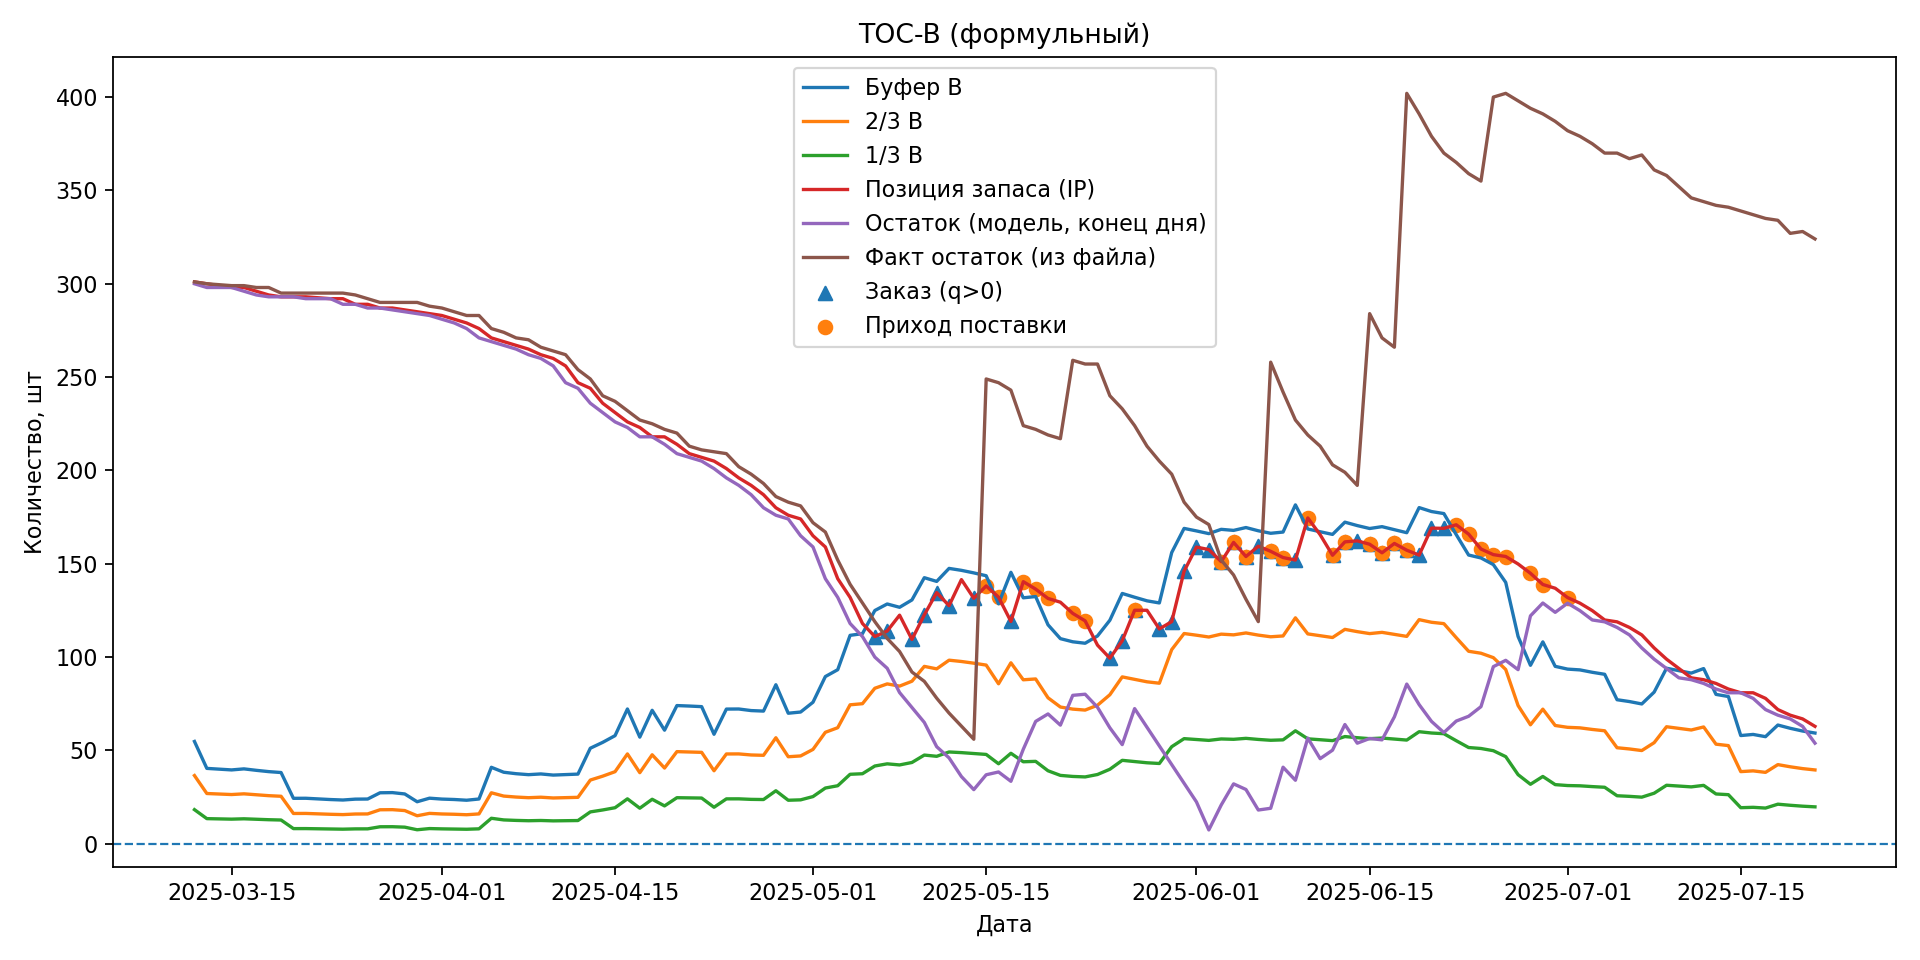

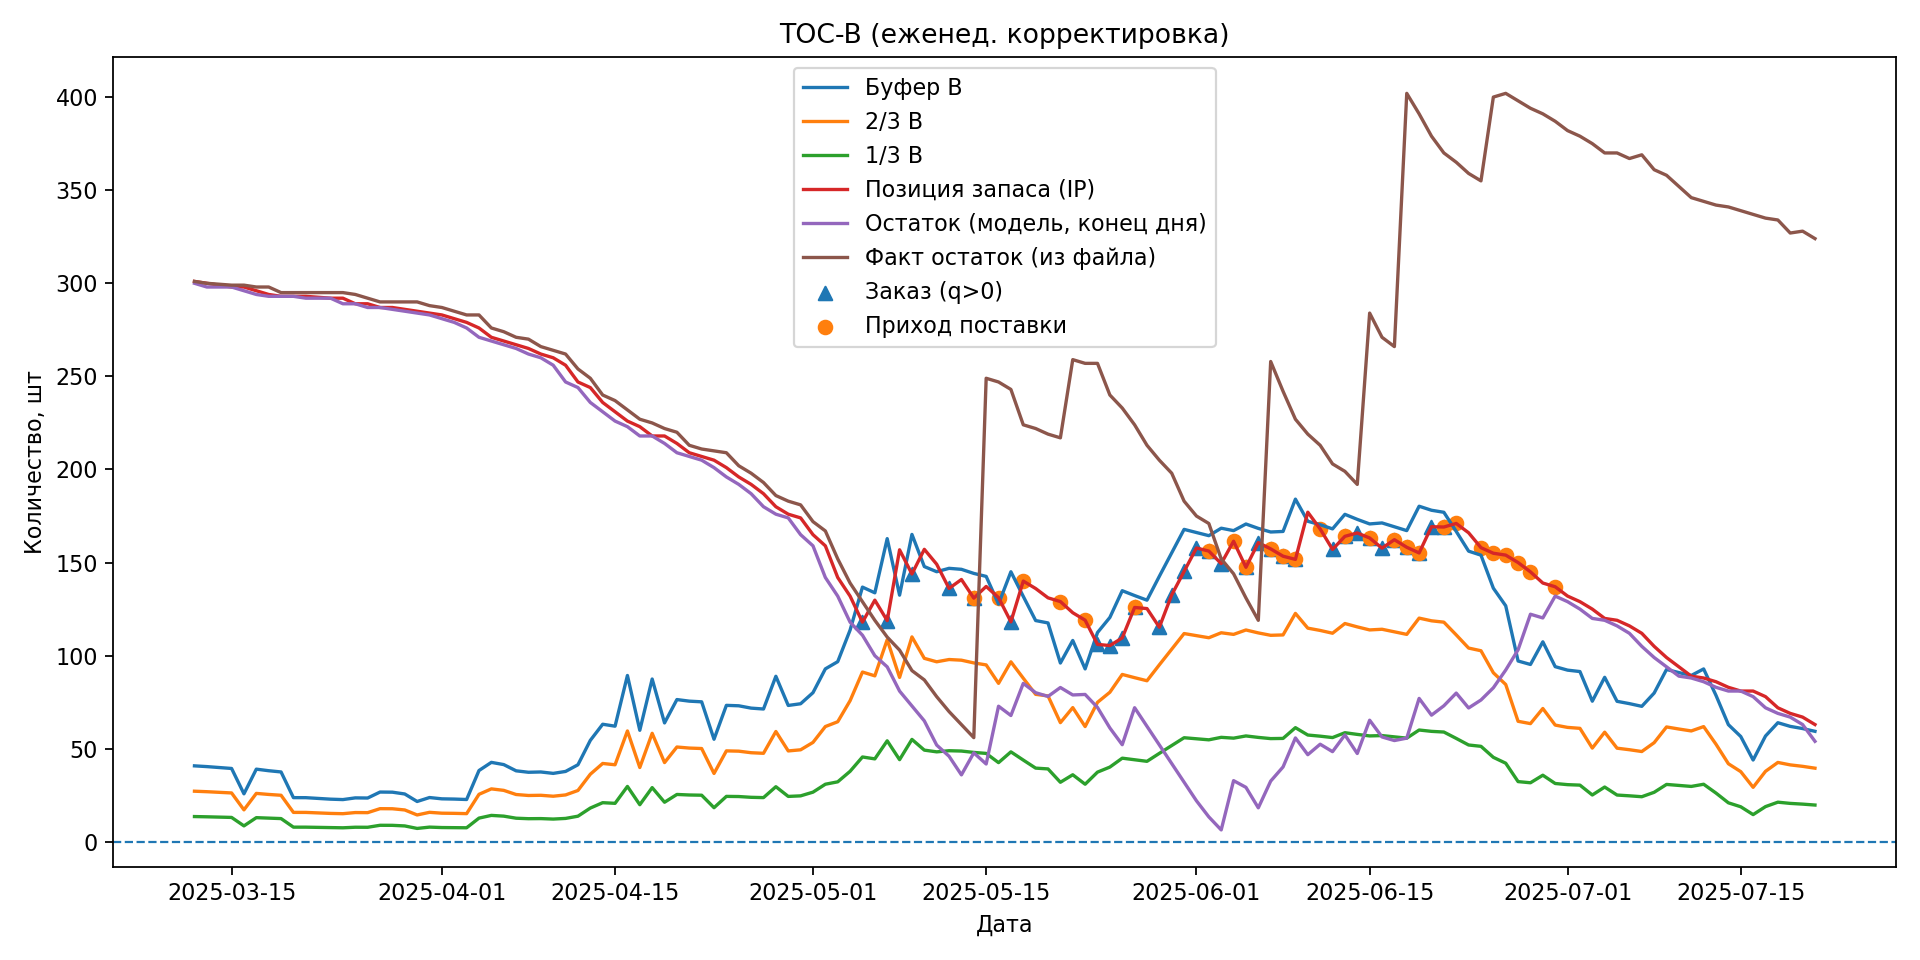

In [32]:
# Через код (Jupyter):
from IPython.display import Image, display
import importlib
import toc_buffer_sim2 as sim  # файл toc_buffer_sim.py лежит рядом с ноутбуком

# название файла с заказами
# orders_stocks = "orders_stocks_236637451.xlsx"
# orders_stocks = "orders_stocks_236637451_2.xlsx"
# orders_stocks = "orders_stocks_155412366.xlsx"
orders_stocks = "orders_stocks_155412366_без_января.xlsx"
# orders_stocks = "orders_stocks_653557424.xlsx"

# 1) Загрузка и маппинг колонок
df_raw = sim.load_table(f"data/{orders_stocks}", sheet="Лист1")
df = sim.autodetect_columns(df_raw,
                            hint_date="date",
                            hint_sales="total_quantity_orders",
                            hint_stock="quantity_stocks")

# 2) Запуск симуляции (формульный ТОС-B)
sim_formal = sim.simulate_tocB(
    df=df,
    L_min=9, L_max=10, R=1,
    h=5.0, quantile_cap=0.90, z=2.33,  # z=1.96, # повысим SLA для снижения OOS
    warmup_days=30,              # количество дней для прогрева (обучения)
    weekly_adjust=False,         # формульный
    expedite_on_red=True,
    floor_policy="max_RT",
    start_mode="actual",
    min_order_qty=6,
    buffer_uplift_mult=1.2,     # ← поднимем буфер на +15%
    buffer_extra_days=1,       # ← и добавим полдня покрытия
)

# 3) Вариант с недельной корректировкой ±33%
sim_weekly = sim.simulate_tocB(
    df=df,
    L_min=9, L_max=10, R=1,
    h=4.0, quantile_cap=0.95, z=2.33,  # z=1.96, # повысим SLA для снижения OOS
    warmup_days=30,               # количество дней для прогрева (обучения)
    weekly_adjust=True,           # включили ±33%
    decrease_rule_green_days=5,
    expedite_on_red=True,
    floor_policy="max_RT",
    start_mode="actual",
    min_order_qty=6,
    buffer_uplift_mult=1.2,     # ← поднимем буфер на +20%
    buffer_extra_days=1,       # ← и добавим полдня покрытия
)

# 4) Графики и CSV
sim.plot_buffer_ip_stock(sim_formal, "ТОС-B (формульный)", "data/out/formal_buffer.png"
                         , base_df=df # отобразить график фактических стоков
                         )
sim.plot_penetration(sim_formal, "ТОС-B (формульный): пенетрация", "data/out/formal_penetration.png")
sim.plot_sales_lambda(sim_formal, df, "Продажи и λ_t (формульный)", "data/out/formal_sales_lambda.png")

sim.plot_buffer_ip_stock(sim_weekly, "ТОС-B (еженед. корректировка)", "data/out/weekly_buffer.png"
                         , base_df=df # отобразить график фактических стоков
                         )
sim.plot_penetration(sim_weekly, "ТОС-B (еженед. корректировка): пенетрация", "data/out/weekly_penetration.png")
sim.plot_sales_lambda(sim_weekly, df, "Продажи и λ_t (еженед.)", "data/out/weekly_sales_lambda.png")

# Сводка метрик по формульному варианту:
sim.summarize(sim_formal)

display(Image(filename="data/out/formal_buffer.png"))
display(Image(filename="data/out/weekly_buffer.png"))

c:\Users\Slivin.Aleksandr\Documents\frst_test_join_dev\Инструмент управления запасами\Моделирование на Python\toc_buffer_sim2.py:285: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df2["stock"] = pd.to_numeric(df2["stock"], errors="coerce").fillna(method="ffill").fillna(0.0)


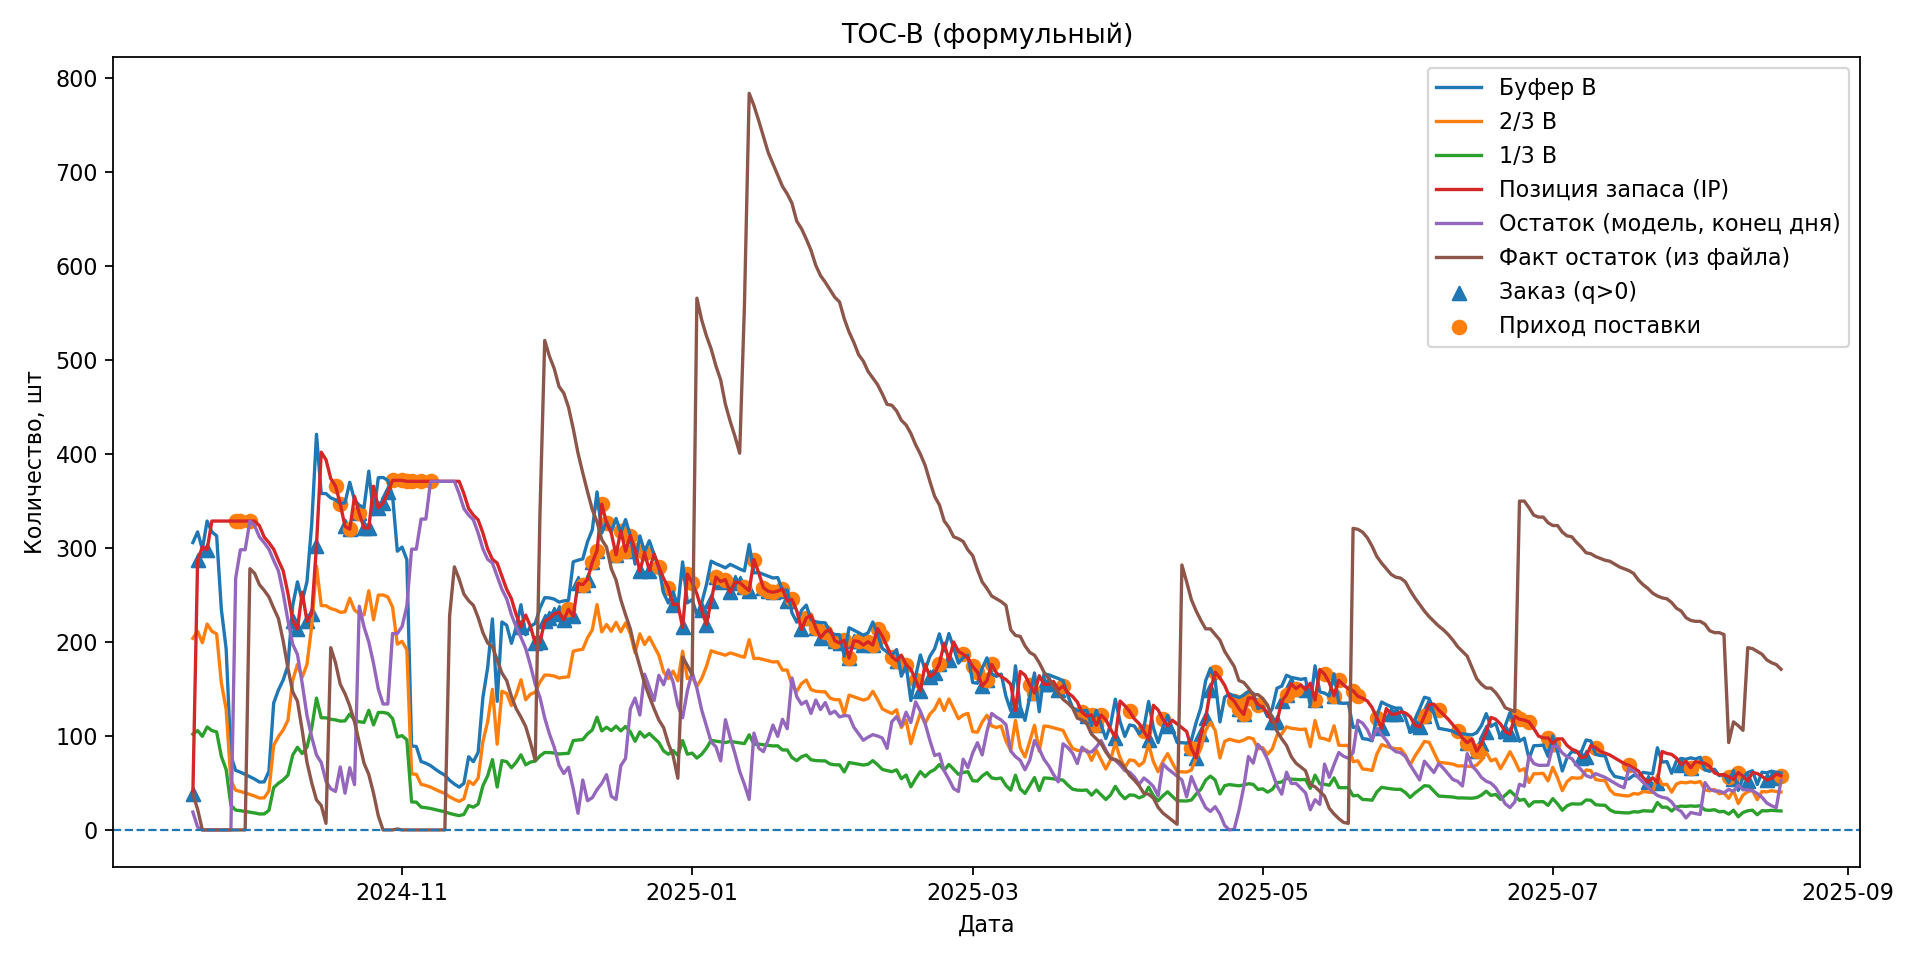

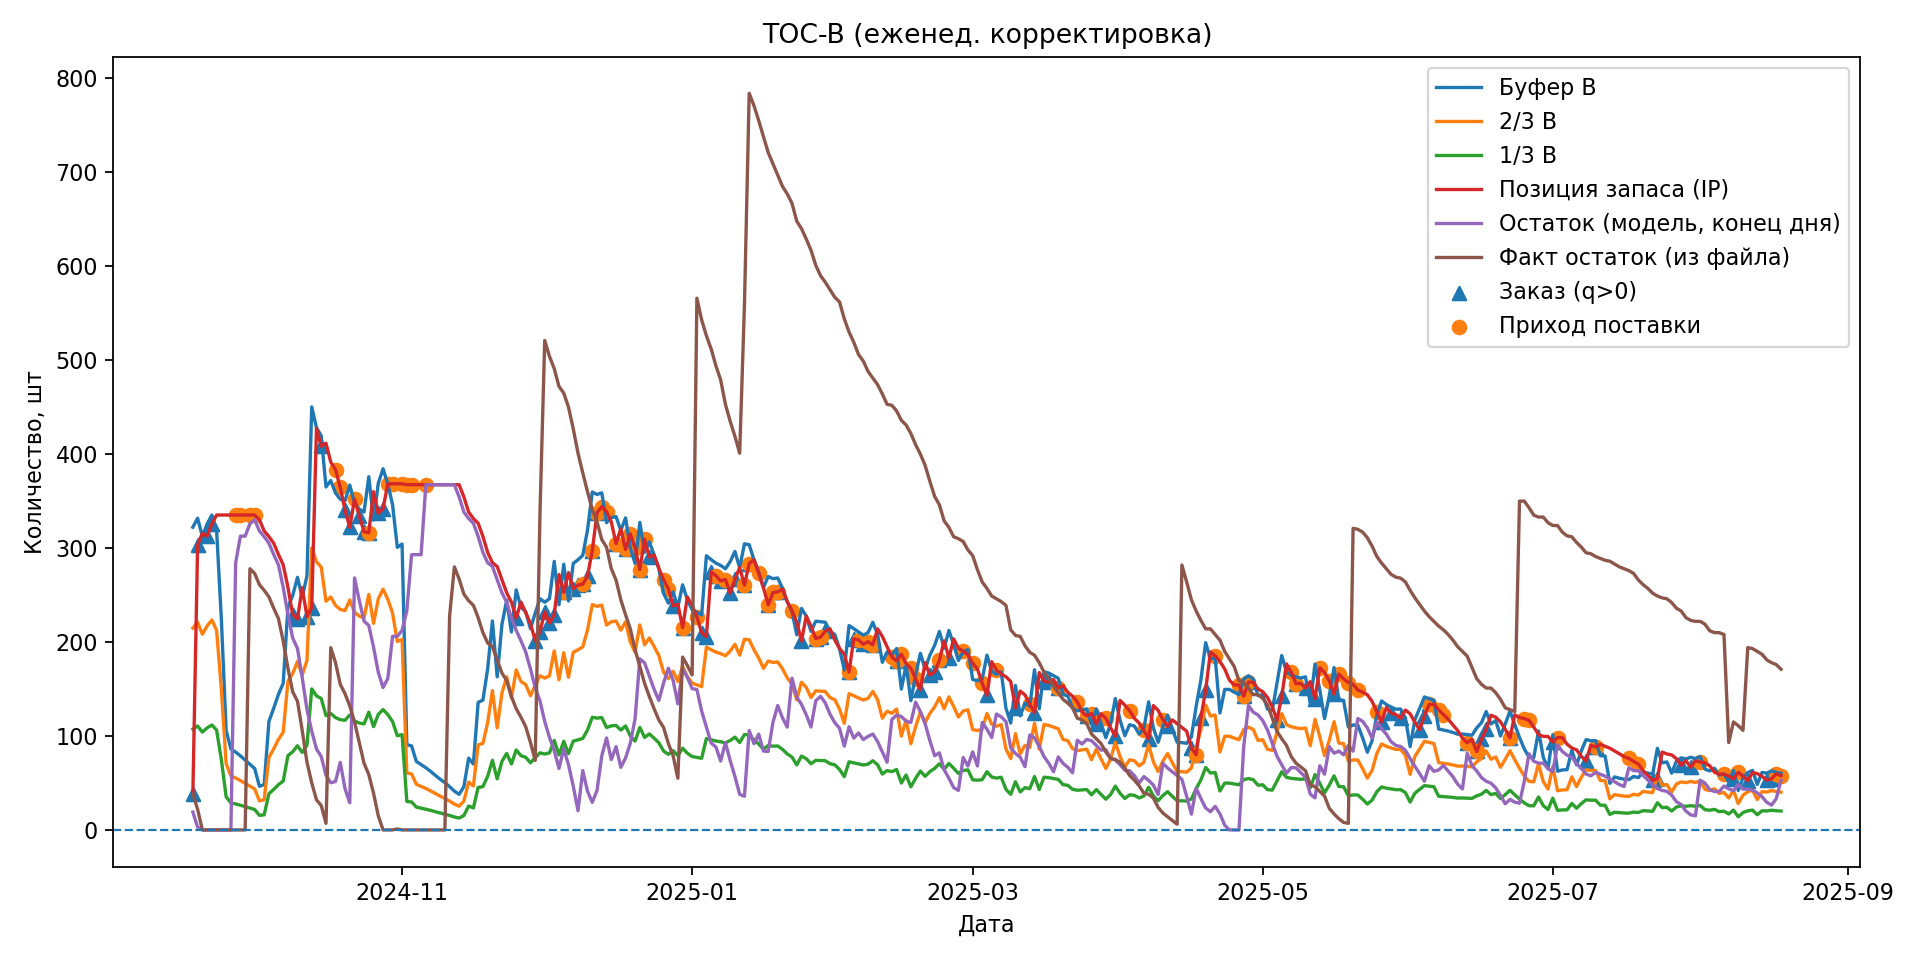

In [7]:
# Через код (Jupyter):
from IPython.display import Image, display
import importlib
import toc_buffer_sim2 as sim  # файл toc_buffer_sim.py лежит рядом с ноутбуком

# название файла с заказами
orders_stocks = "orders_stocks_236637451.xlsx"
# orders_stocks = "orders_stocks_236637451_2.xlsx"
# orders_stocks = "orders_stocks_155412366.xlsx"
# orders_stocks = "orders_stocks_155412366_без_января.xlsx"
# orders_stocks = "orders_stocks_653557424.xlsx"
# orders_stocks = "orders_stocks_1291136584.xlsx"

# 1) Загрузка и маппинг колонок
df_raw = sim.load_table(f"data/{orders_stocks}", sheet="Лист1")
df = sim.autodetect_columns(df_raw,
                            hint_date="date",
                            hint_sales="total_quantity_orders",
                            hint_stock="quantity_stocks")

# 2) Запуск симуляции (формульный ТОС-B)
sim_formal = sim.simulate_tocB(
    df=df,
    L_min=9, L_max=10, R=1,
    h=5.0, quantile_cap=0.90, z=2.33,  # z=1.96, # повысим SLA для снижения OOS
    warmup_days=30,              # количество дней для прогрева (обучения)
    weekly_adjust=False,         # формульный
    expedite_on_red=True,
    floor_policy="max_RT",
    start_mode="actual",
    min_order_qty=6,
    buffer_uplift_mult=1.2,     # ← поднимем буфер на +15%
    buffer_extra_days=1,       # ← и добавим полдня покрытия
)

# 3) Вариант с недельной корректировкой ±33%
sim_weekly = sim.simulate_tocB(
    df=df,
    L_min=9, L_max=10, R=1,
    h=4.0, quantile_cap=0.95, z=2.33,  # z=1.96, # повысим SLA для снижения OOS
    warmup_days=30,               # количество дней для прогрева (обучения)
    weekly_adjust=True,           # включили ±33%
    decrease_rule_green_days=5,
    expedite_on_red=True,
    floor_policy="max_RT",
    start_mode="actual",
    min_order_qty=6,
    buffer_uplift_mult=1.2,     # ← поднимем буфер на +20%
    buffer_extra_days=1,       # ← и добавим полдня покрытия
)

# 4) Графики и CSV
sim.plot_buffer_ip_stock(sim_formal, "ТОС-B (формульный)", "data/out/formal_buffer.png"
                         , base_df=df # отобразить график фактических стоков
                         )
sim.plot_penetration(sim_formal, "ТОС-B (формульный): пенетрация", "data/out/formal_penetration.png")
sim.plot_sales_lambda(sim_formal, df, "Продажи и λ_t (формульный)", "data/out/formal_sales_lambda.png")

sim.plot_buffer_ip_stock(sim_weekly, "ТОС-B (еженед. корректировка)", "data/out/weekly_buffer.png"
                         , base_df=df # отобразить график фактических стоков
                         )
sim.plot_penetration(sim_weekly, "ТОС-B (еженед. корректировка): пенетрация", "data/out/weekly_penetration.png")
sim.plot_sales_lambda(sim_weekly, df, "Продажи и λ_t (еженед.)", "data/out/weekly_sales_lambda.png")

# Сводка метрик по формульному варианту:
sim.summarize(sim_formal)

display(Image(filename="data/out/formal_buffer.png"))
display(Image(filename="data/out/weekly_buffer.png"))

- что с практической точки такое weekly_adjust=True
- мы сделали, что меньше 6шт не заказываем: В итоге заказываем позднее и на меньшую, чем потребуется к приходу, величину - это почему еще? мы ведь в момент заказа пересчитывать сколько нам нужно заказать и заказываем по потребности
- если заказов было мало, чтобы буфер не уменьшался донельзя